## Functions and Data

In [1]:
import datetime
import copy


import numpy as np
from numpy.random import normal as rnorm, multinomial as rmultinomial
import scipy.stats
from scipy.special import logsumexp, loggamma
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge, LogisticRegression, LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)


In [2]:
import seaborn as sns

In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=sm.tools.sm_exceptions.DomainWarning)

In [4]:
plt.style.use('ggplot')

In [5]:
data_W = pd.read_excel(r"data/Hourly Weather and No Outlier Wachapreague Data.xlsx", parse_dates=[r"Date"])
data_W = data_W.drop(
    columns=["Wind Direction (degrees)", "Water Level Anomalies (m)"]
    ).rename(
    columns = {"Date": "time_min", 
                "Wind Speed (m/s)": "wind",
               "Air Pressure (mb)": "airpressure",
               "Precipitation (mm/hr)": "precipitation", 
               "Temperature ©": "temperature",
               "Salinity (ppt)": "salinity",
               "DO (mg/L)": "ODO",
               "Water Level (m)": "waterlevel",
               "Log10(Chl+1) (log10(ug/L))": "log10_chlorophyll",
              }
    ).set_index("time_min")

data_W["chlorophyll"] = data_W["log10_chlorophyll"].map(lambda x: np.power(10, x))
data_W["date"] = data_W.index.date
#data_W = data_W.dropna()

# data_W = pd.read_excel(r"data/Corrected W All.xlsx", sheet_name = "Sheet1", parse_dates=[r"Combine"],)
# data_W = data_W.drop(
#     columns=["MM/DD/YY", "HH:mm:SS", "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "Unnamed: 15"]
#     ).rename(
#     columns = {"Combine": "time_min",
#                "Temp ('C)": "temperature",
#                "SpCond (ms/cm)": "conductivity",
#                "Salinity (ppt)": "salinity",
#                "ODO (mg/L)": "ODO",
#                "Turb (NTU)": "turbidity",
#                "Chl (ug/L)": "chlorophyll",
#               }
#     ).set_index("time_min")
# data_W["date"] = data_W.index.date
# data_W["log10_chlorophyll"] = data_W["chlorophyll"].map(np.log10)
# data_W = data_W.dropna()


In [6]:
data_W

,wind,airpressure,precipitation,temperature,salinity,ODO,log10_chlorophyll,waterlevel,chlorophyll,date
time_min,,,,,,,,,,
2016-03-25 20:00:00,1.870,1012.210000,0.76,16.70975,30.9550,8.0425,0.360495,0.938,2.293480,2016-03-25
2016-03-25 21:00:00,2.500,1013.730000,0.53,16.43975,31.2575,7.8200,0.319070,1.127,2.084826,2016-03-25
2016-03-25 22:00:00,3.690,1014.980000,0.20,15.83275,31.4425,7.8650,0.327645,1.268,2.126401,2016-03-25
2016-03-25 23:00:00,4.180,1015.490000,0.03,15.43950,31.4775,7.8525,0.330899,1.324,2.142390,2016-03-25
2016-03-26 00:00:00,3.150,1016.750000,0.00,15.45900,31.3925,7.7400,0.325592,1.238,2.116372,2016-03-26
...,...,...,...,...,...,...,...,...,...,...
2022-12-31 18:00:00,0.625,1011.325000,0.02,7.93175,30.2575,10.6000,0.358752,0.8,2.284292,2022-12-31
2022-12-31 19:00:00,1.800,1011.310000,NaN,8.10550,30.1100,10.5450,0.359835,NaN,2.289997,2022-12-31
2022-12-31 20:00:00,2.120,1010.420000,NaN,8.65100,28.9200,10.2250,0.429598,NaN,2.689042,2022-12-31


In [7]:

data_WW = pd.read_excel(r"data/VIMS WQ Data.xlsx", sheet_name = "WW", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )
data_WW_2 = pd.read_excel(r"data/2022-Willis_Wharf ALL Raw (1).xlsx", skiprows = 7, na_values = {"pH": [0.0]}, parse_dates=[r"Date/Time Combined", r"MM/DD/YY"], )

data_WW = data_WW.drop(
    columns=["Unnamed: 17", "Unnamed: 18", "MM/DD/YY.1", "Flagged or Deleted Data/Notes", "Log10 chl", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)", "Day"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW_2 = data_WW_2.drop(
    columns=["Unnamed: 16", "Unnamed: 17", "Unnamed: 18", "Unnamed: 19", "Unnamed: 20", 
             "pH (mv)", "ODO (%sat)", "BGA-PE (ug/L)", "Battery (volts)", "Sonde SN", "HH:mm:SS", "TSS (mg/L)"],
    ).rename(
    columns = {"MM/DD/YY": "date", 
               "Date/Time Combined": "time_min",
               "Temp ('C)": "temperature",
               "SpCond (ms/cm)": "conductivity",
               "Salinity (ppt)": "salinity",
               "ODO (mg/L)": "ODO",
               "Turb (NTU)": "turbidity",
               "Chl (ug/L)": "chlorophyll",
              }
    ).set_index("time_min")

data_WW = pd.concat([data_WW[data_WW.index.year < 2022], data_WW_2])
data_WW["log10_chlorophyll"] = data_WW["chlorophyll"].map(np.log10)
#data_WW = data_WW.dropna()


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)
d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: invalid value encountered in log10
  new_values = map_f(values, mapper)


In [8]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


## EDA (WW)

#### Data: top-1, top-2, 90-Q, 50-Q

In [79]:

# # 1stmax
# data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
# data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
# data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()

# # 2ndmax
# data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
# data_WW_byday["date"] = data_WW["date"].resample("1D").max()
# data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
# data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)

# 90-quantile
data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
data_WW_byday["date"] = data_WW["date"].resample("1D").max()
data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.1) if len(x) >= 2 else np.nan)
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.9) if len(x) >= 2 else np.nan)


In [80]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

data_WW_byday = data_WW_byday.resample("1D").max()


In [81]:
data_WW_byday_90Q = data_WW_byday.copy()

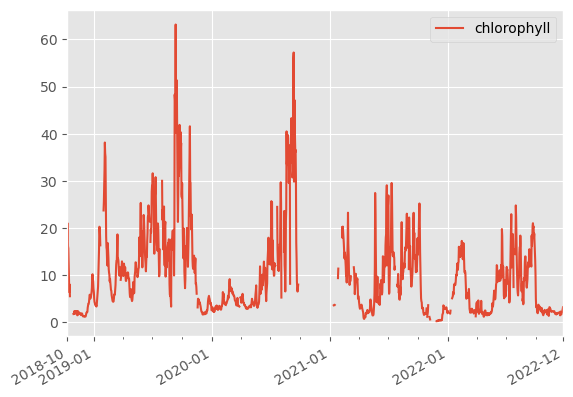

In [82]:
data_WW_byday_90Q["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

In [50]:

# 50-quantile
data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
data_WW_byday["date"] = data_WW["date"].resample("1D").max()
data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.6) if len(x) >= 2 else np.nan)
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: np.quantile(x, 0.4) if len(x) >= 2 else np.nan)
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: np.quantile(x, 0.5) if len(x) >= 2 else np.nan)


In [51]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

data_WW_byday = data_WW_byday.resample("1D").max()


In [52]:
data_WW_byday_50Q = data_WW_byday.copy()

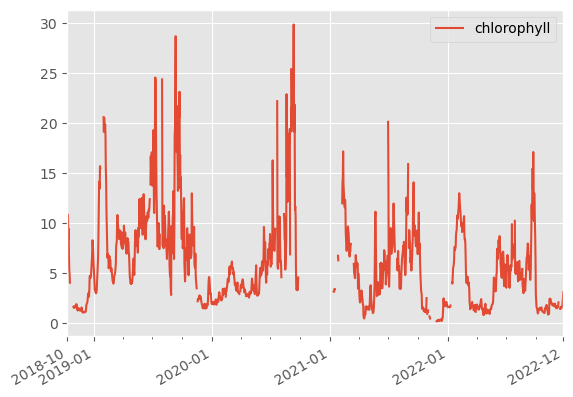

In [70]:
data_WW_byday_50Q["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

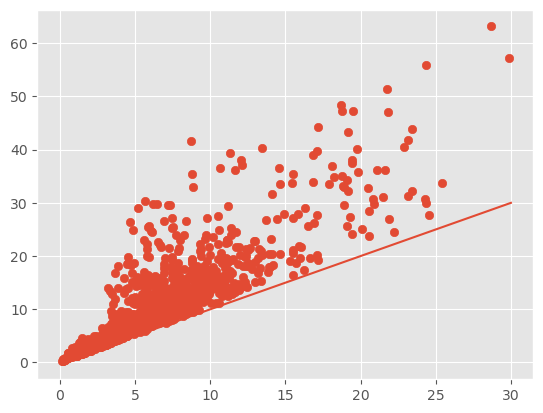

In [93]:
plt.scatter(data_WW_byday_50Q["chlorophyll"], data_WW_byday_90Q["chlorophyll"])
plt.plot([0, 30], [0,30], "-" )
plt.show()

In [87]:
len(data_WW_byday_50Q["chlorophyll"].dropna()), len(data_WW_byday_90Q["chlorophyll"].dropna())

(1302, 1302)

In [61]:

# 1stmax
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").max()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").max()


In [62]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

data_WW_byday = data_WW_byday.resample("1D").max()


In [63]:
data_WW_byday_top1 = data_WW_byday.copy()

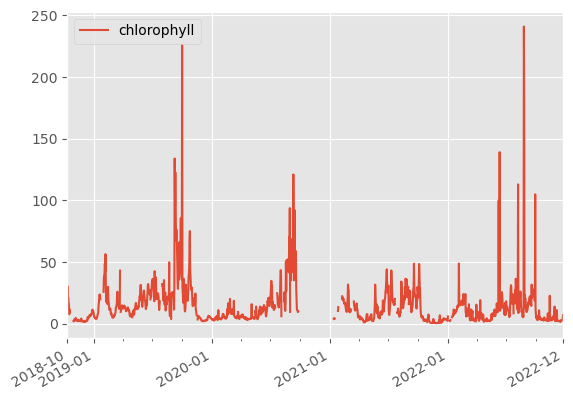

In [83]:
data_WW_byday_top1["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

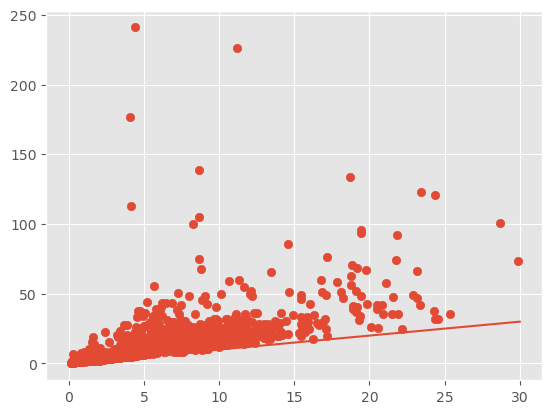

In [94]:
plt.scatter(data_WW_byday_50Q["chlorophyll"], data_WW_byday_top1["chlorophyll"])
plt.plot([0, 30], [0,30], "-" )
plt.show()

In [88]:

# 2ndmax
data_WW_byday = data_WW[["temperature", "pH"]].resample("1D").mean()
data_WW_byday["date"] = data_WW["date"].resample("1D").max()
data_WW_byday["conductivity"] = data_WW["conductivity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["turbidity"] = data_WW["turbidity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").apply(lambda x: x.nsmallest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").apply(lambda x: x.nlargest(2).iloc[-1] if len(x) > 0 else np.nan)


In [89]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

data_WW_byday = data_WW_byday.resample("1D").max()


In [90]:
data_WW_byday_top2 = data_WW_byday.copy()

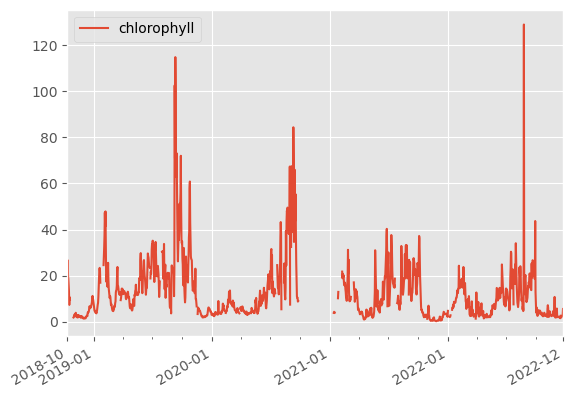

In [91]:
data_WW_byday_top2["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

In [92]:
len(data_WW_byday_top2["chlorophyll"].dropna())

1327

In [269]:

# smallest
data_WW_byday = data_WW[["date", "conductivity", "turbidity"]].resample("1D").min()
data_WW_byday["temperature"] = data_WW["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW["salinity"].resample("1D").min()
data_WW_byday["salinity_min"] = data_WW["salinity"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW["log10_chlorophyll"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW["chlorophyll"].resample("1D").min()


In [270]:
data_W_byday = data_W[["date"]].resample("1D").max()
data_W_byday["wind"] = data_W["wind"].resample("1D").mean()

data_WW_byday = data_WW_byday.merge(data_W_byday, left_index=True, right_index=True).dropna()

data_WW_byday = data_WW_byday.resample("1D").max()


In [271]:
data_WW_byday_smallest = data_WW_byday.copy()

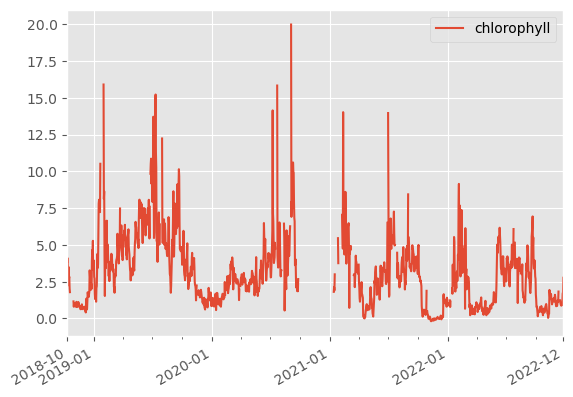

In [272]:
data_WW_byday_smallest["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()

#### Corr analysis


In [275]:
data_WW_difftop = (data_WW_byday_top1[["chlorophyll"]].
                   merge(data_WW_byday_top2[["chlorophyll"]], left_index=True, right_index=True, how = "outer").
                   rename(columns = {"chlorophyll_x": "top1", "chlorophyll_y": "top2", }).
                   merge(data_WW_byday_90Q[["chlorophyll"]], left_index=True, right_index=True, how = "outer").
                   rename(columns = {"chlorophyll": "90Q", }).
                   merge(data_WW_byday_50Q[["chlorophyll"]], left_index=True, right_index=True, how = "outer").
                   rename(columns = {"chlorophyll": "50Q", }).
                   merge(data_WW_byday_smallest[["chlorophyll"]], left_index=True, right_index=True, how = "outer").
                   rename(columns = {"chlorophyll": "smallest", }))


In [276]:
data_WW_difftop

,top1,top2,90Q,50Q,smallest
time_min,,,,,
2018-10-12,19.75,19.28,17.660,8.230,3.87
2018-10-13,30.23,26.70,21.020,9.295,4.10
2018-10-14,22.01,20.24,16.170,10.825,3.36
2018-10-15,21.38,18.73,15.730,8.380,2.26
2018-10-16,16.66,16.29,12.495,9.405,3.50
...,...,...,...,...,...
2022-12-20,2.69,2.59,2.220,1.655,0.94
2022-12-21,2.88,2.86,2.515,1.715,1.11
2022-12-22,3.66,3.03,2.815,2.220,1.69


In [277]:
data_WW_difftop.corr()

,top1,top2,90Q,50Q,smallest
top1,1.000000,0.852979,0.752382,0.623409,0.452998
top2,0.852979,1.000000,0.932137,0.782721,0.581572
90Q,0.752382,0.932137,1.000000,0.883735,0.697212
50Q,0.623409,0.782721,0.883735,1.000000,0.863908
smallest,0.452998,0.581572,0.697212,0.863908,1.000000


In [278]:
list_top1, list_top2, list_90Q, list_50Q, list_smallest = [], [], [], [], []
for ii in range(10000):
    
    #tmp_sample = np.random.normal(size = 100)
    #tmp_sample = np.random.standard_t(size = 100, df = 2)
    #tmp_sample = np.random.standard_exponential(size = 100)
    tmp_sample = np.random.uniform(size = 100)
    
    tmp_sample.sort()
    list_top1.append(tmp_sample[-1])
    list_top2.append(tmp_sample[-2])
    list_90Q.append(tmp_sample[-10])
    list_50Q.append(tmp_sample[-50])
    list_smallest.append(tmp_sample[0])
    
np.corrcoef([list_top1, list_top2, list_90Q, list_50Q, list_smallest])


array([[1.        , 0.69966891, 0.30170638, 0.10113999, 0.01035128],
       [0.69966891, 1.        , 0.42536007, 0.143715  , 0.0201845 ],
       [0.30170638, 0.42536007, 1.        , 0.33453955, 0.02475123],
       [0.10113999, 0.143715  , 0.33453955, 1.        , 0.0857845 ],
       [0.01035128, 0.0201845 , 0.02475123, 0.0857845 , 1.        ]])

In [282]:
data_WW_difftop_rate = data_WW_difftop.applymap(lambda x: np.log(x) if x > 0 else np.nan).diff()

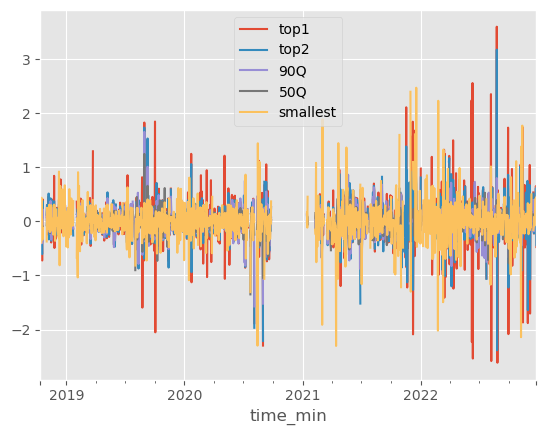

In [283]:
data_WW_difftop_rate.plot()
plt.show()

In [284]:
data_WW_difftop_rate.describe()

,top1,top2,90Q,50Q,smallest
count,1299.000000,1299.000000,1269.000000,1269.000000,1264.000000
mean,-0.000165,-0.002298,-0.001323,-0.001919,0.000597
std,0.444111,0.331385,0.228240,0.190189,0.365423
min,-2.613095,-2.382667,-1.572404,-1.349573,-2.302585
25%,-0.162498,-0.147969,-0.113019,-0.092318,-0.136644
50%,-0.011101,-0.013072,0.000000,0.000000,0.000000
75%,0.162751,0.146450,0.110174,0.088215,0.137004
max,3.600472,3.177357,1.656328,1.248127,2.472003


In [285]:
data_WW_difftop_rate.apply(lambda x: pd.Series({">1": np.mean(x.map(abs) > 1), ">2": np.mean(x.map(abs) > 2), }))

,top1,top2,90Q,50Q,smallest
>1,0.031922,0.014332,0.003257,0.002606,0.021498
>2,0.008469,0.001954,0.000000,0.000000,0.004560


In [264]:
data_WW_difftop_rate.corr()

,top1,top2,90Q,50Q
top1,1.000000,0.772255,0.552680,0.290551
top2,0.772255,1.000000,0.730356,0.389382
90Q,0.552680,0.730356,1.000000,0.610621
50Q,0.290551,0.389382,0.610621,1.000000


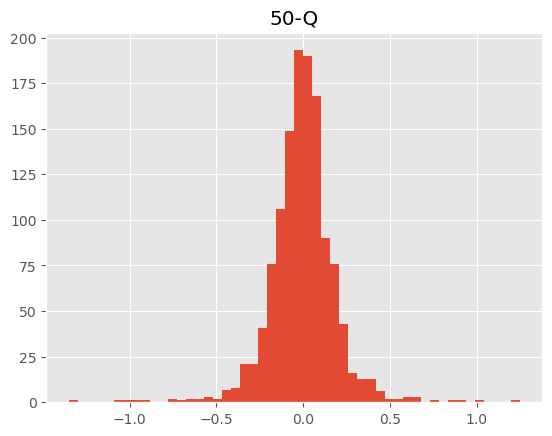

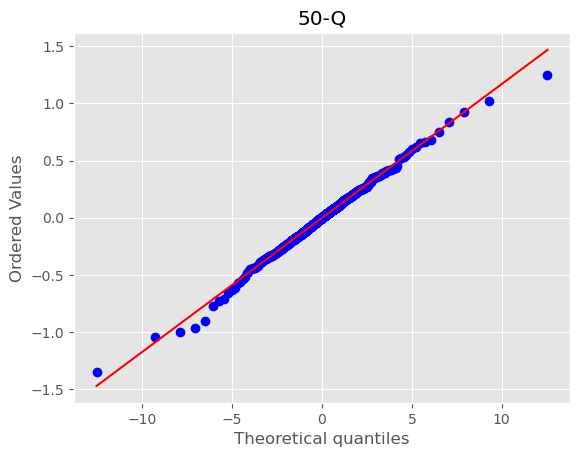

In [499]:
data_WW_difftop_rate["50Q"].hist(bins = 50)
plt.title("50-Q")
plt.show()

scipy.stats.probplot(data_WW_difftop_rate["50Q"].dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("50-Q")
plt.show()


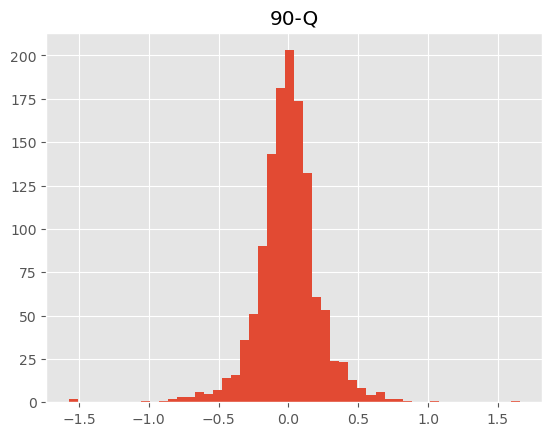

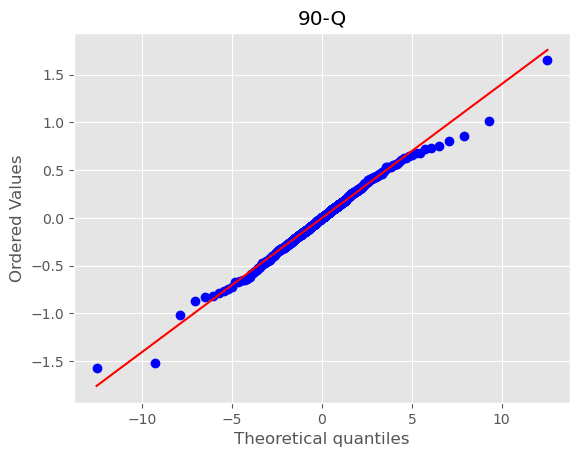

In [500]:
data_WW_difftop_rate["90Q"].hist(bins = 50)
plt.title("90-Q")
plt.show()

scipy.stats.probplot(data_WW_difftop_rate["90Q"].dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("90-Q")
plt.show()

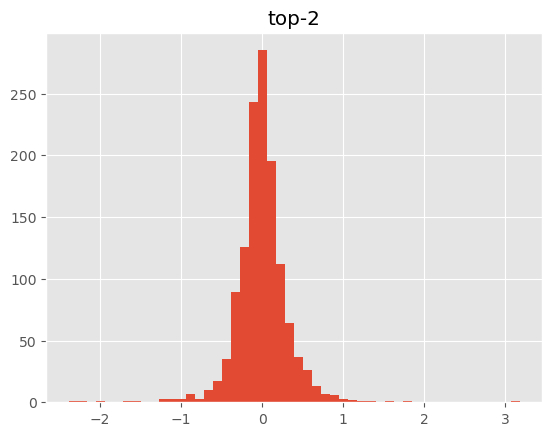

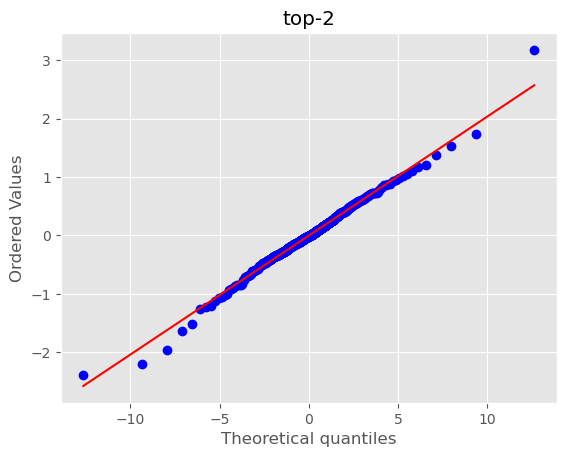

In [501]:
data_WW_difftop_rate["top2"].hist(bins = 50)
plt.title("top-2")
plt.show()

scipy.stats.probplot(data_WW_difftop_rate["top2"].dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("top-2")
plt.show()

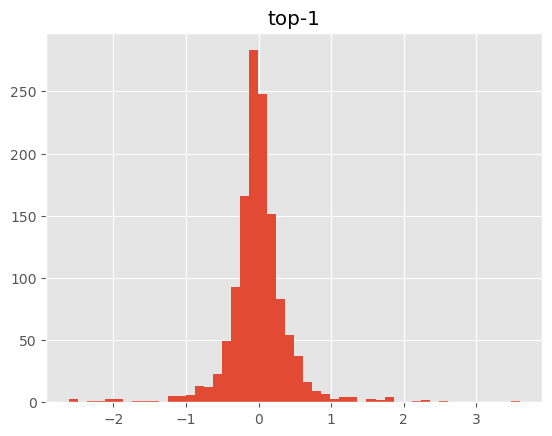

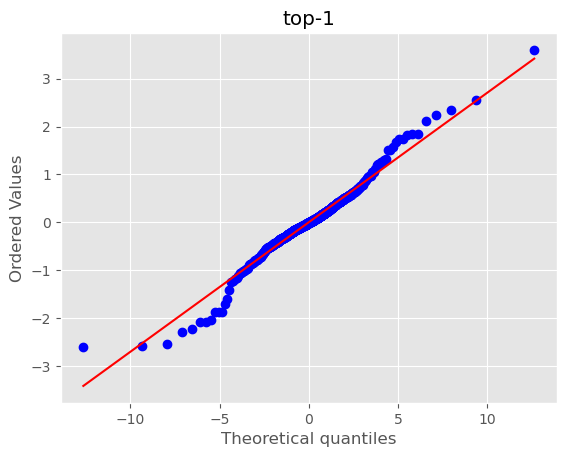

In [502]:
data_WW_difftop_rate["top1"].hist(bins = 50)
plt.title("top-1")
plt.show()

scipy.stats.probplot(data_WW_difftop_rate["top1"].dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("top-1")
plt.show()

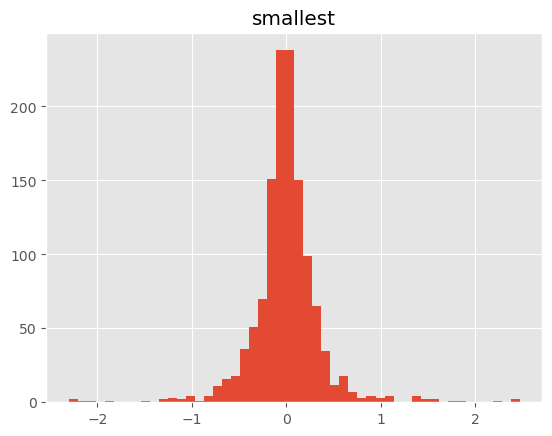

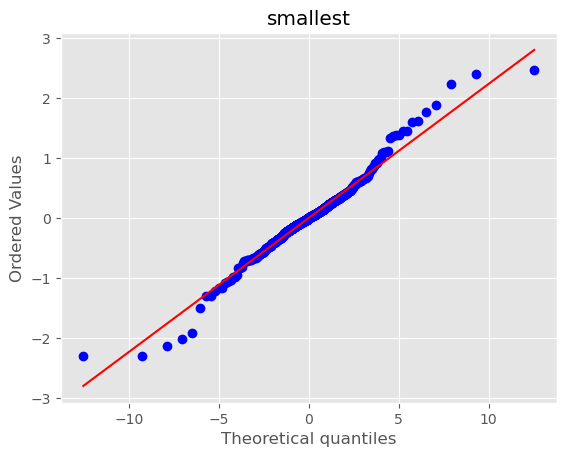

In [503]:
data_WW_difftop_rate["smallest"].hist(bins = 50)
plt.title("smallest")
plt.show()

scipy.stats.probplot(data_WW_difftop_rate["smallest"].dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("smallest")
plt.show()


#### Hourly increase rate

In [213]:
data_WW.resample("1h").max()

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:00:00,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 13:00:00,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-12 14:00:00,2018-10-12,24.940,46.755,30.38,7.86,6.81,23.71,7.67,0.884795
2018-10-12 15:00:00,2018-10-12,24.963,46.282,30.03,7.87,7.12,32.46,6.91,0.839478
2018-10-12 16:00:00,2018-10-12,24.854,45.864,29.73,7.92,7.75,47.06,9.55,0.980003
...,...,...,...,...,...,...,...,...,...
2022-12-24 02:00:00,2022-12-24,6.138,47.450,30.38,7.90,9.60,18.38,3.18,0.502427
2022-12-24 03:00:00,2022-12-24,5.739,47.173,30.14,7.89,9.68,25.67,3.28,0.515874
2022-12-24 04:00:00,2022-12-24,4.811,46.548,29.59,7.86,9.80,22.81,3.16,0.499687


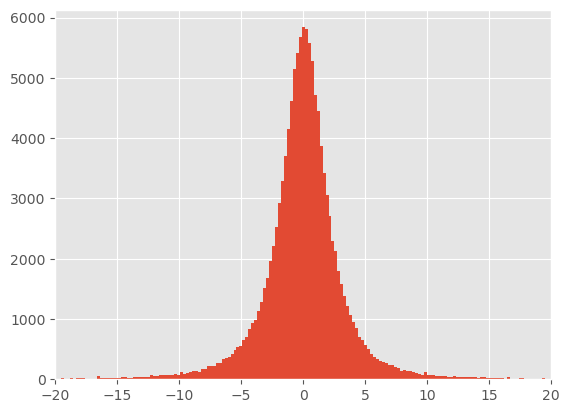

In [221]:
(data_WW["chlorophyll"].map(lambda x: np.log(x) if x > 0 else np.nan).diff() * 24).hist(bins = 1000)
plt.xlim(-20, 20)
plt.show()

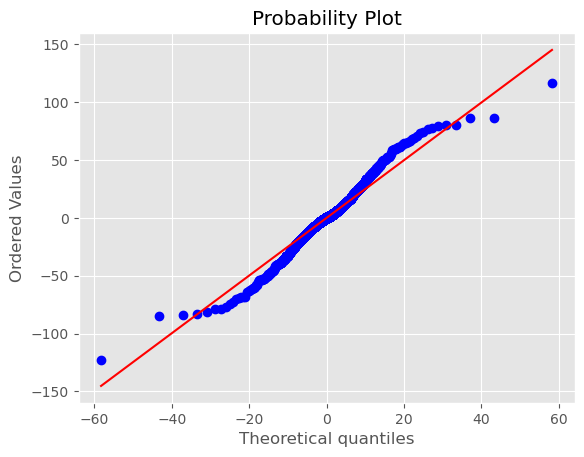

In [239]:
scipy.stats.probplot((data_WW["chlorophyll"].map(lambda x: np.log(x) if x > 0 else np.nan).diff() * 24).dropna().to_list(), sparams = (3), dist = "t", plot=plt)
plt.show()

## Smoothing

C:\Users\noah_\AppData\Local\Temp\ipykernel_4532\1270667259.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


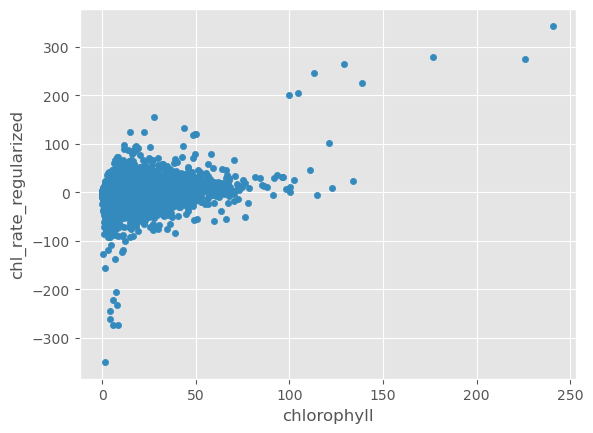

In [9]:
data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["log_chlorophyll_p5"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(x + 5))

data_WW_smooth_diff = data_WW_smooth.diff()
data_WW_smooth["chl_rate_regularized"] = data_WW_smooth_diff["log_chlorophyll_p5"] / data_WW_smooth_diff["datetime"].map(lambda x: x.value / (10 ** 9) / (3600 * 24)).fillna(0.)
data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.

data_WW_smooth.plot.scatter(x = "chlorophyll", y = "chl_rate_regularized")
plt.show()


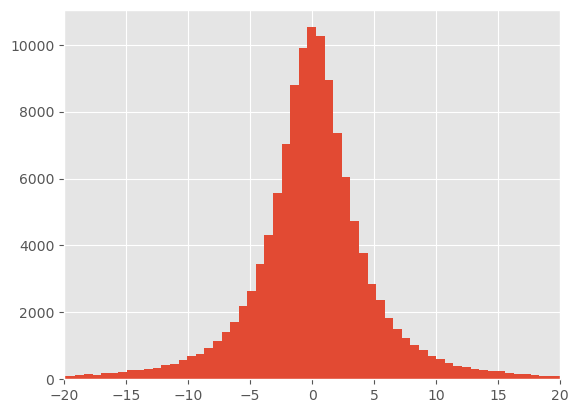

In [10]:
data_WW_smooth["chl_rate_regularized"].hist(bins = 1000)
plt.xlim(-20, 20)
plt.show()

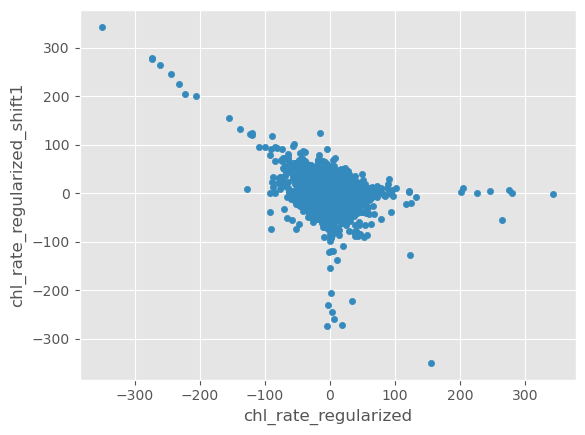

In [11]:
data_WW_smooth["chl_rate_regularized_shift1"] = data_WW_smooth["chl_rate_regularized"].shift(1)
data_WW_smooth.plot.scatter(x = "chl_rate_regularized", y = "chl_rate_regularized_shift1")
plt.show()

In [12]:
data_WW_smooth


,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll,datetime,log_chlorophyll,log_chlorophyll_p5,chl_rate_regularized,chl_rate_regularized_shift1
time_min,,,,,,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711,2018-10-12 12:53:04,1.353255,2.182675,0.000000,NaN
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089,2018-10-12 14:03:38,1.846879,2.428336,5.013026,0.000000
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233,2018-10-12 14:17:40,1.941615,2.482404,5.547990,5.013026
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795,2018-10-12 14:32:41,2.037317,2.539237,5.449958,5.547990
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104,2018-10-12 14:47:41,1.991976,2.512035,-2.611361,5.449958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121,2022-12-24 05:02:12,1.098612,2.079442,-1.901052,2.862704
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958,2022-12-24 05:17:12,1.128171,2.090629,1.073970,-1.901052
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721,2022-12-24 05:32:12,1.118415,2.086914,-0.356657,1.073970


C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


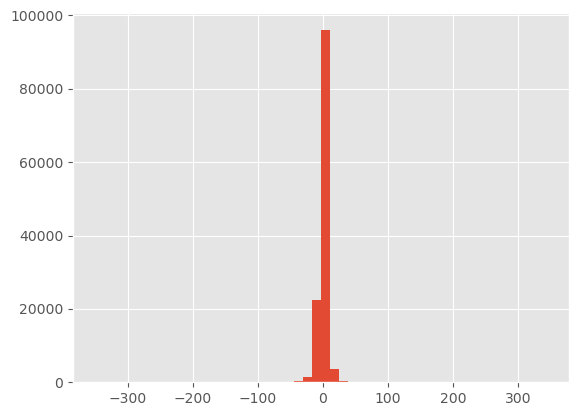

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


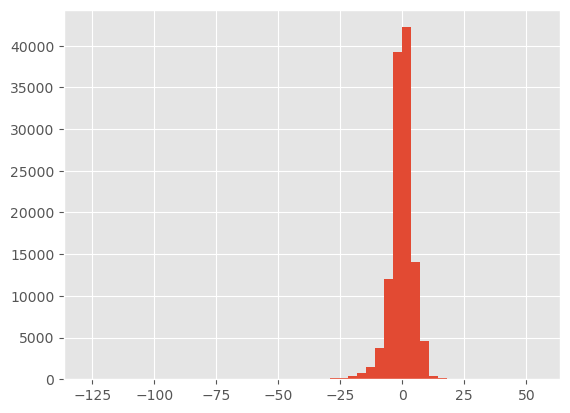

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


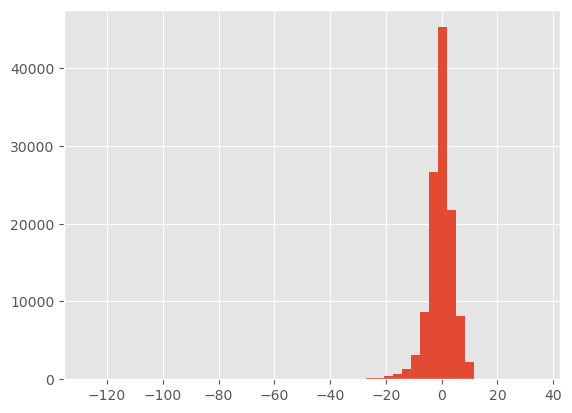

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


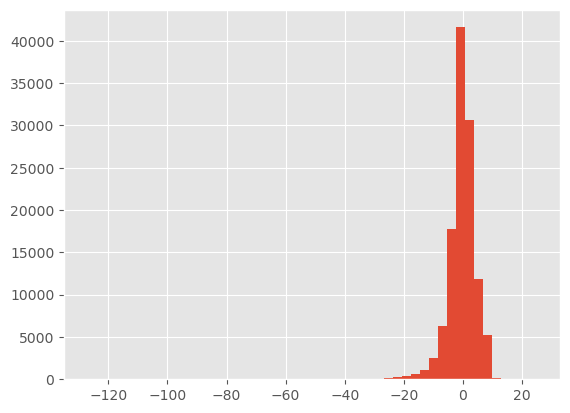

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


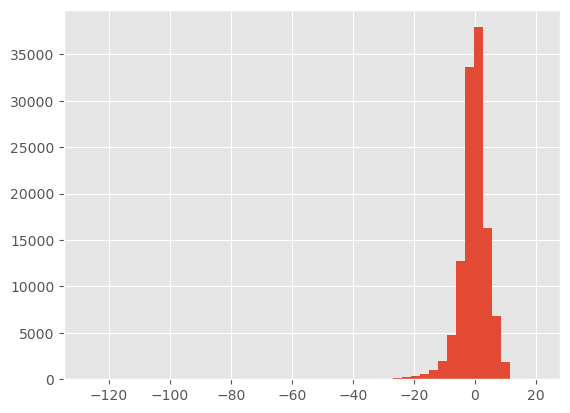

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


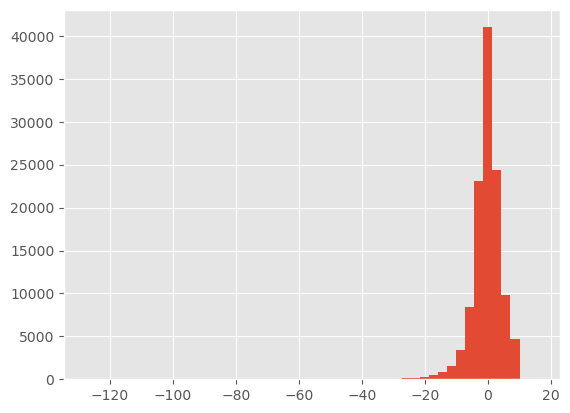

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


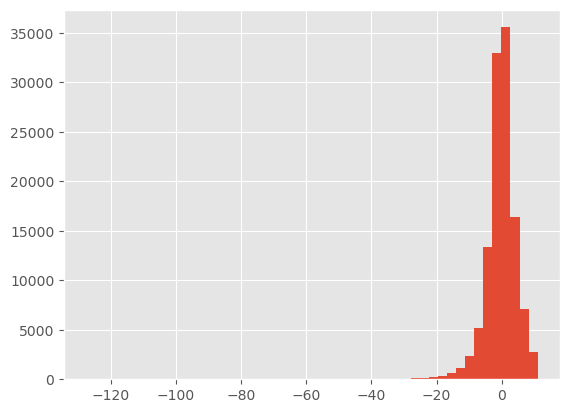

C:\Users\noah_\AppData\Local\Temp\ipykernel_11416\4213529920.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.


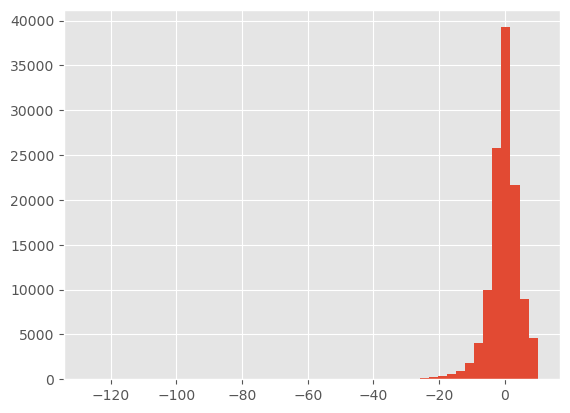

In [644]:
data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["log_chlorophyll_p5"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(x + 5))

while True:
    
    data_WW_smooth_diff = data_WW_smooth.diff()
    data_WW_smooth["chl_rate_regularized"] = data_WW_smooth_diff["log_chlorophyll_p5"] / data_WW_smooth_diff["datetime"].map(lambda x: x.value / (10 ** 9) / (3600 * 24)).fillna(0.)
    data_WW_smooth["chl_rate_regularized"].iloc[0] = 0.
    
    data_WW_smooth["chl_rate_regularized"].hist(bins = 50)
    plt.show()
    
    data_WW_smooth["chlorophyll"] = data_WW_smooth.apply(lambda x: x["chlorophyll"] if x["chl_rate_regularized"] < 10 else np.nan, axis = 1)
    
    if data_WW_smooth.isnull().any().any():
        data_WW_smooth = data_WW_smooth.dropna()
    else:
        break
        

In [13]:
data_WW_smooth

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll,datetime,log_chlorophyll,log_chlorophyll_p5,chl_rate_regularized,chl_rate_regularized_shift1
time_min,,,,,,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711,2018-10-12 12:53:04,1.353255,2.182675,0.000000,NaN
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089,2018-10-12 14:03:38,1.846879,2.428336,5.013026,0.000000
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233,2018-10-12 14:17:40,1.941615,2.482404,5.547990,5.013026
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795,2018-10-12 14:32:41,2.037317,2.539237,5.449958,5.547990
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104,2018-10-12 14:47:41,1.991976,2.512035,-2.611361,5.449958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121,2022-12-24 05:02:12,1.098612,2.079442,-1.901052,2.862704
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958,2022-12-24 05:17:12,1.128171,2.090629,1.073970,-1.901052
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721,2022-12-24 05:32:12,1.118415,2.086914,-0.356657,1.073970


In [185]:

# forward_period, backward_period, n_std, offset_std = "1day", '1day', 10, 1   # smoothtrim1
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 2, 1   # smoothtrim10
# forward_period, backward_period, n_std, offset_std = "1hour", '1hour', 3, 1   # smoothtrim9 untrimmed
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 5, 1 
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 3, 1   
# forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 5, 1   # smoothtrim18 untrimmed
forward_period, backward_period, n_std, offset_std = "2hour", '2hour', 5, 1   # smoothtrim17 trimmed

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
    tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    # tmp_trimmed_mean = np.mean(tmp_neighbors)
    # tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + offset_std, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))


n_invalid = 113


In [ ]:

# forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "2hour", '2hour', 2, 1, 1, False   # smoothmeanstd4
# forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '24hour', 3, 3, 1, True   # smoothmeanstd12
# forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "6hour", '6hour', 3, 3, 5, False   # smoothmeanstd9
# forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "12hour", '12hour', 3, 3, 1, True   # smoothmeanstd10
forward_period, backward_period, n_std, n_mean, offset_divergence, is_trimmed = "24hour", '0hour', 3, 3, 1, True   # smoothmeanstd14

data_WW_smooth = data_WW.copy()
data_WW_smooth["datetime"] = data_WW_smooth.index
data_WW_smooth["chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: max(x, 0.))
data_WW_smooth["log_chlorophyll"] = data_WW_smooth["chlorophyll"].map(lambda x: np.log(max(x, 1.)))

data_WW_smooth["trimmed_mean"] = 0.
data_WW_smooth["trimmed_std"] = 0.
data_WW_smooth["is_valid"] = False

# using trimmed mean with time weighting (approx: within a time period)
for cc, (tmp_index, tmp_line) in enumerate(data_WW_smooth.iterrows()):
    
    tmp_left = tmp_index - pd.Timedelta(forward_period)
    tmp_right = tmp_index + pd.Timedelta(backward_period)
    tmp_neighbors = data_WW_smooth[data_WW_smooth.index.to_series().between(tmp_left, tmp_right)]["chlorophyll"].to_numpy()
    if is_trimmed:
        tmp_trimmed_mean = scipy.stats.trim_mean(tmp_neighbors, 0.1)
        tmp_trimmed_std = np.sqrt(scipy.stats.mstats.trimmed_var(tmp_neighbors, 0.1))
    else:
        tmp_trimmed_mean = np.mean(tmp_neighbors)
        tmp_trimmed_std = np.std(tmp_neighbors)
    
    data_WW_smooth.at[tmp_index, "trimmed_mean"] = tmp_trimmed_mean
    data_WW_smooth.at[tmp_index, "trimmed_std"] = tmp_trimmed_std
    
data_WW_smooth["is_valid"] = data_WW_smooth.apply(lambda x: abs(x["chlorophyll"] - x["trimmed_mean"]) < n_std * x["trimmed_std"] + n_mean * x["trimmed_mean"] + offset_divergence, axis = 1)

print("n_invalid =", len(data_WW_smooth) - np.sum(data_WW_smooth["is_valid"]))


In [ ]:
print(len(data_WW_smooth), data_WW_smooth["is_valid"].sum())

In [ ]:
data_WW_smooth[~data_WW_smooth["is_valid"]]

In [ ]:
data_WW_smooth = data_WW_smooth[data_WW_smooth["is_valid"]]

In [ ]:
data_WW_smooth

In [ ]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()


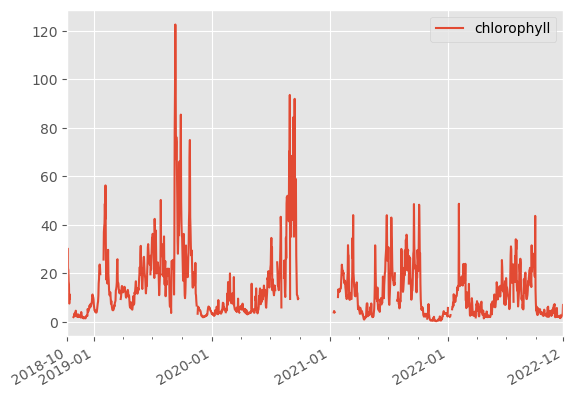

In [29]:
data_WW_smooth["chlorophyll"].resample("1D").max().plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.savefig('plots/chl_plot_smooth14.png')
plt.show()

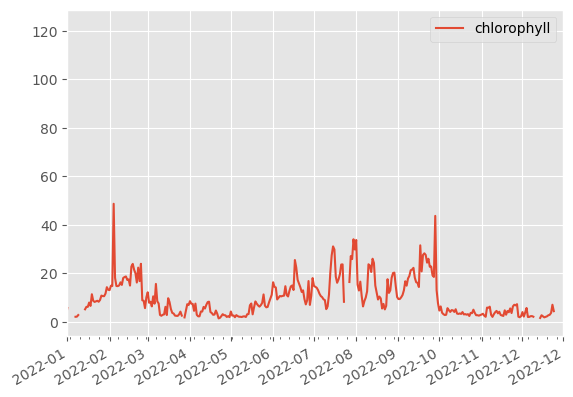

In [30]:
data_WW_smooth["chlorophyll"].resample("1D").max().plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp('2022-01-01'), pd.Timestamp('2022-12-31'))
plt.savefig('plots/chl_plot_2022_smooth14.png')
plt.show()

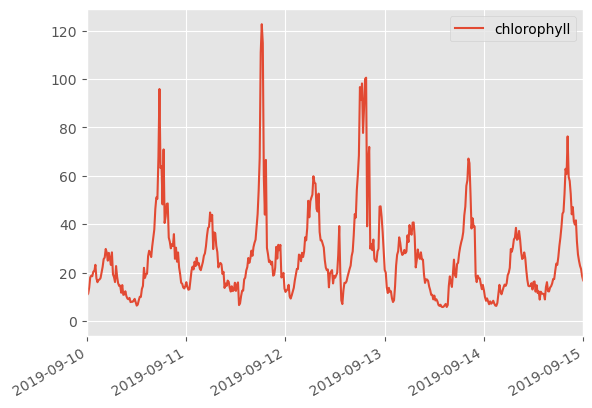

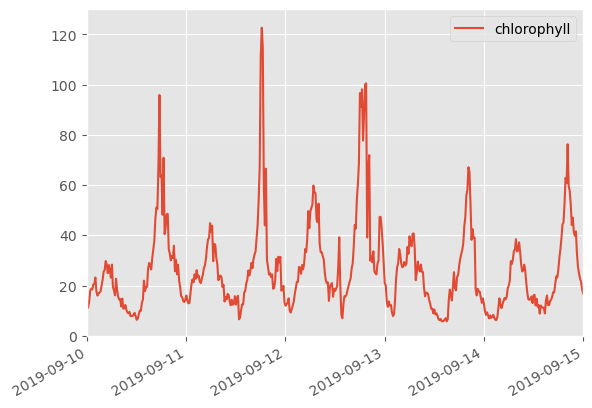

In [325]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.ylim(0, 130)
plt.savefig(r"plots/chl_190910_190915_volatility_source.png")
plt.show()


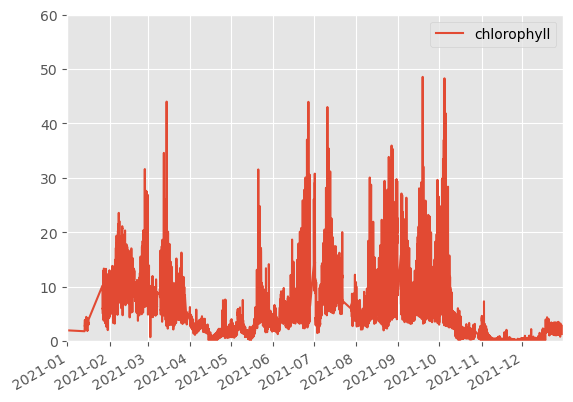

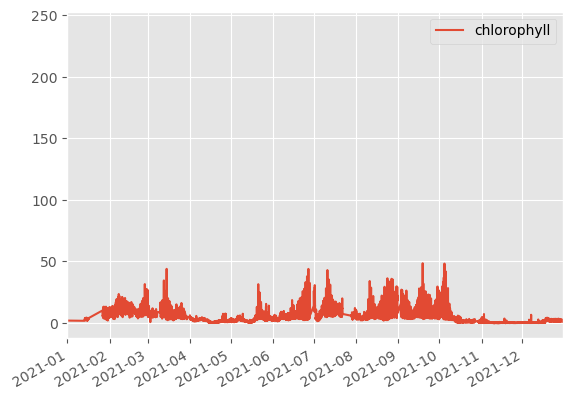

In [282]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2021-01-01"), pd.Timestamp("2021-12-31"))
plt.ylim(0, 60)
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2021-01-01"), pd.Timestamp("2021-12-31"))
plt.show()


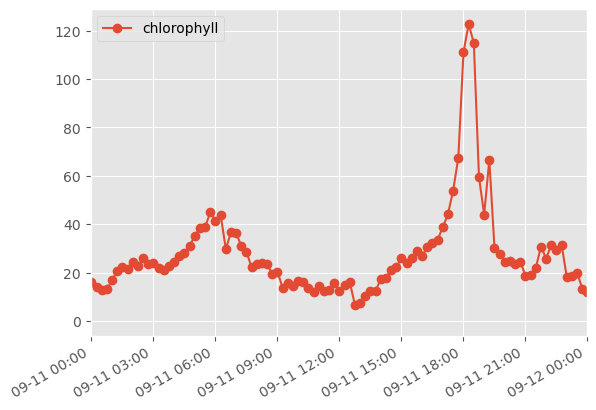

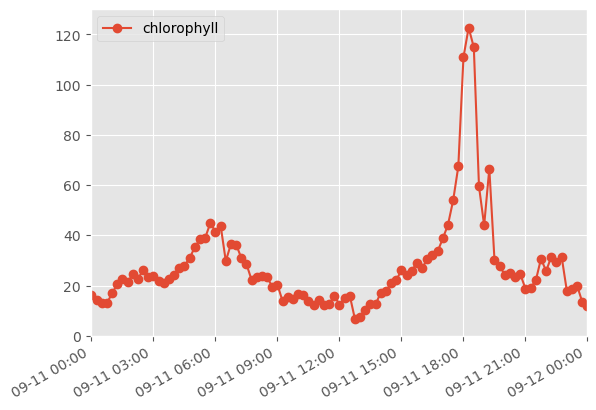

In [324]:
data_WW_smooth["chlorophyll"].plot(marker='o')
plt.legend()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-11"), pd.Timestamp("2019-09-12"))
plt.show()

data_WW["chlorophyll"].plot(marker='o')
plt.legend()
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-11"), pd.Timestamp("2019-09-12"))
plt.ylim(0, 130)
plt.savefig(r"plots/chl_190911_volatile.png")
plt.show()


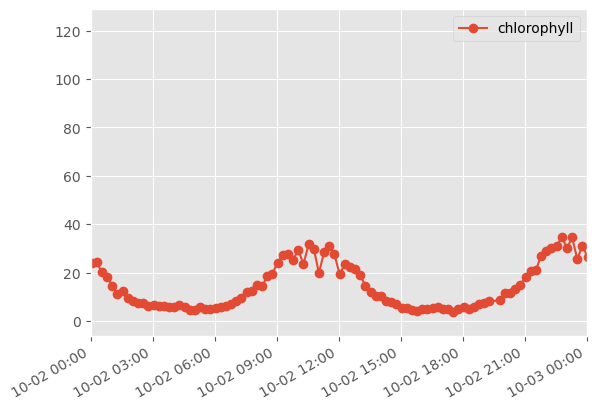

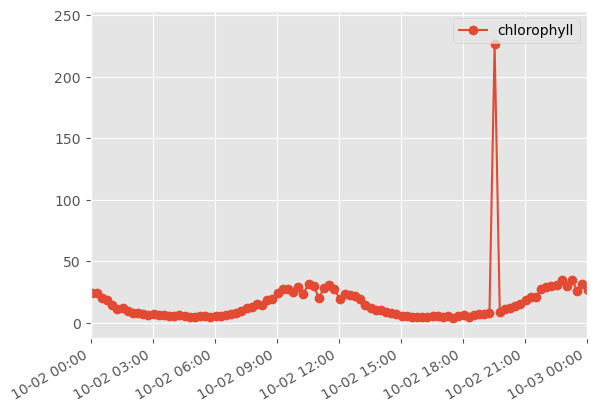

In [323]:
data_WW_smooth["chlorophyll"].plot(marker='o')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-10-02"), pd.Timestamp("2019-10-03"))
# plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()

data_WW["chlorophyll"].plot(marker='o')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-10-02"), pd.Timestamp("2019-10-03"))
plt.savefig(r"plots/chl_191002_outlier.png")
plt.show()


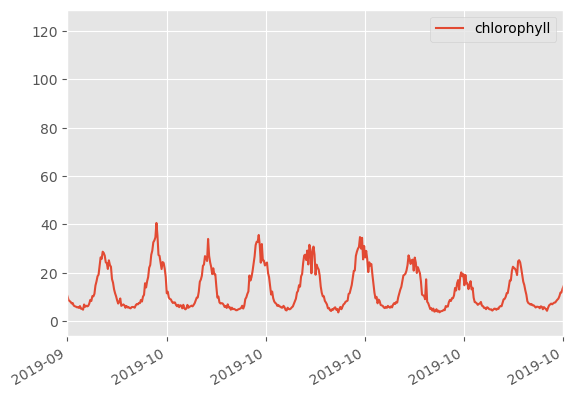

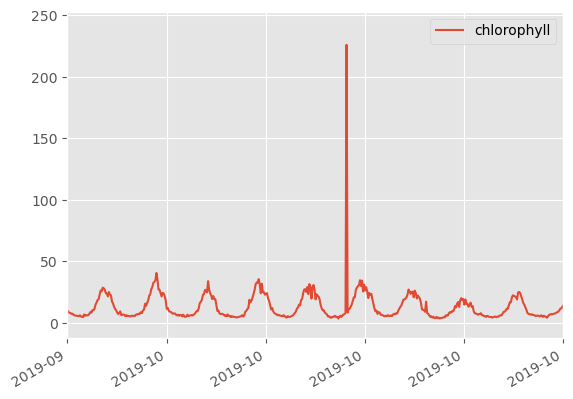

In [264]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-09-30"), pd.Timestamp("2019-10-05"))
# plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-09-30"), pd.Timestamp("2019-10-05"))
# plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()


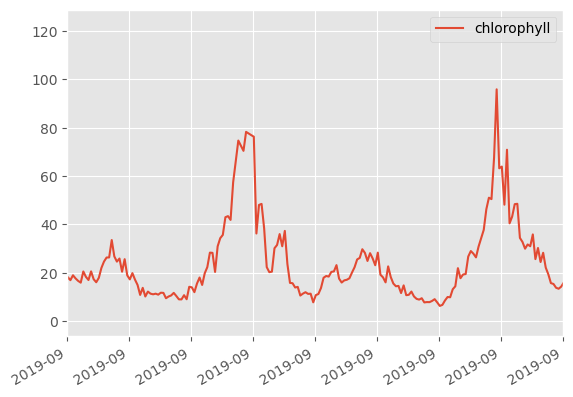

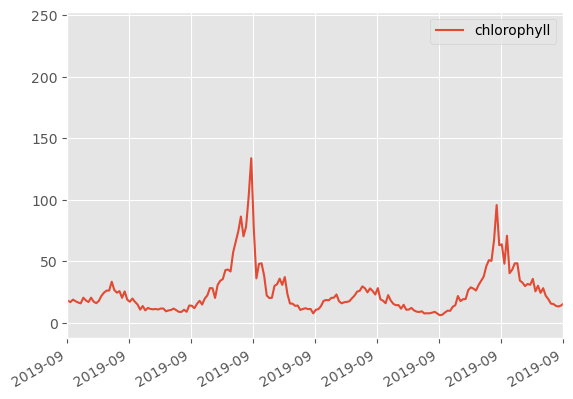

In [270]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-09-09"), pd.Timestamp("2019-09-11"))
# plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-09-09"), pd.Timestamp("2019-09-11"))
# plt.xlim(pd.Timestamp("2019-09-10"), pd.Timestamp("2019-09-15"))
plt.show()


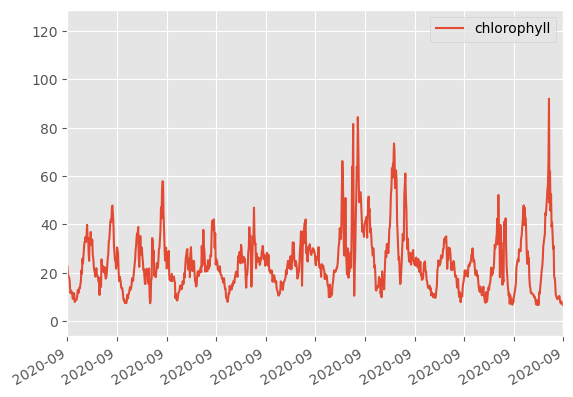

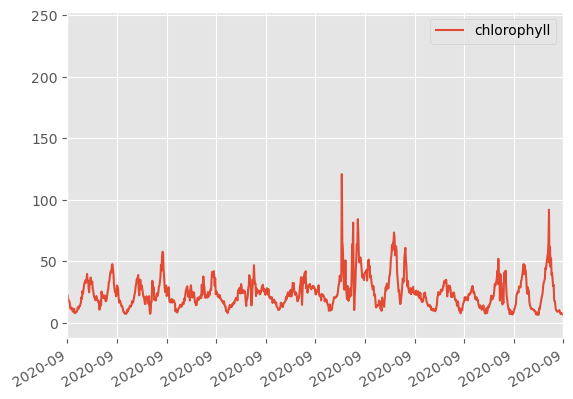

In [257]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2020-09-05"), pd.Timestamp("2020-09-15"))
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2020-09-05"), pd.Timestamp("2020-09-15"))
plt.show()

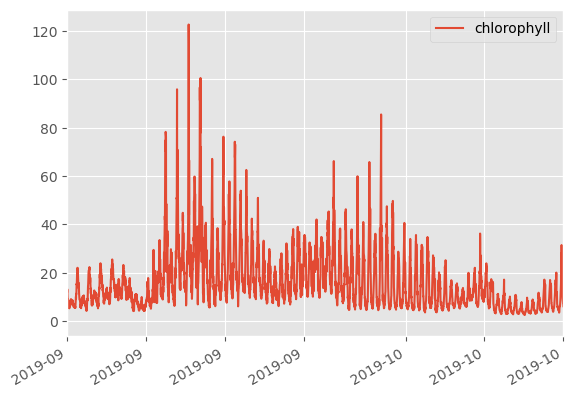

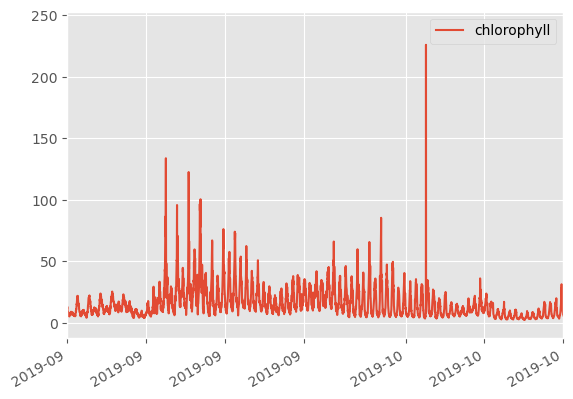

In [258]:
data_WW_smooth["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-15"))
plt.show()

data_WW["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
# plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-01"))
plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-10-15"))
plt.show()


In [283]:
data_WW_byday = data_WW_smooth[["date", "conductivity", "turbidity"]].resample("1D").max()
data_WW_byday["temperature"] = data_WW_smooth["temperature"].resample("1D").mean()
data_WW_byday["pH"] = data_WW_smooth["pH"].resample("1D").mean()
data_WW_byday["ODO"] = data_WW_smooth["ODO"].resample("1D").min()
data_WW_byday["salinity_max"] = data_WW_smooth["salinity"].resample("1D").max()
data_WW_byday["salinity_min"] = data_WW_smooth["salinity"].resample("1D").min()
data_WW_byday["chlorophyll"] = data_WW_smooth["chlorophyll"].resample("1D").max()
data_WW_byday["log10_chlorophyll"] = data_WW_smooth["chlorophyll"].map(np.log10)


d:\Tools\anaconda3\lib\site-packages\pandas\core\base.py:880: RuntimeWarning: divide by zero encountered in log10
  new_values = map_f(values, mapper)


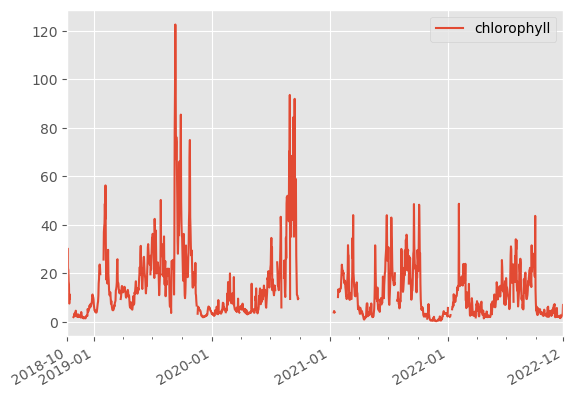

In [284]:
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.show()


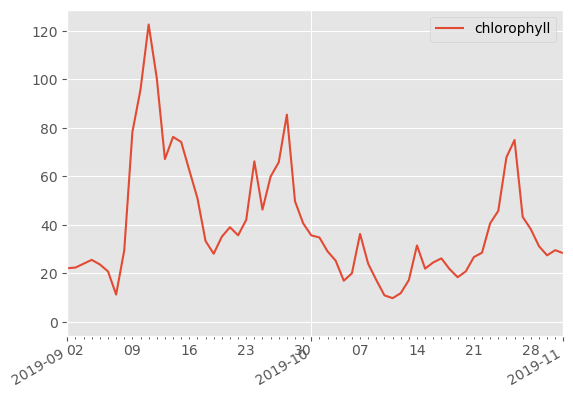

In [285]:
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2019-09-01"), pd.Timestamp("2019-11-01"))
plt.show()


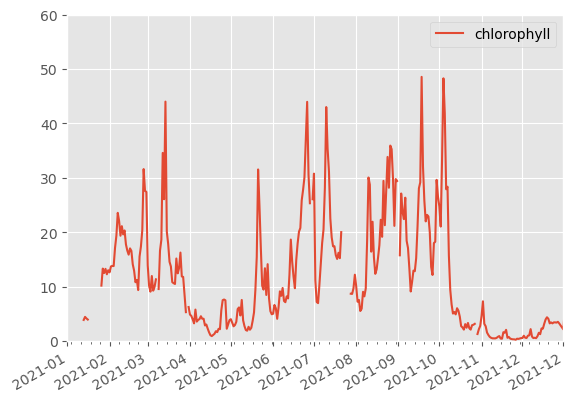

In [288]:
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2021-01-01"), pd.Timestamp("2021-12-31"))
plt.ylim(0, 60)
plt.show()


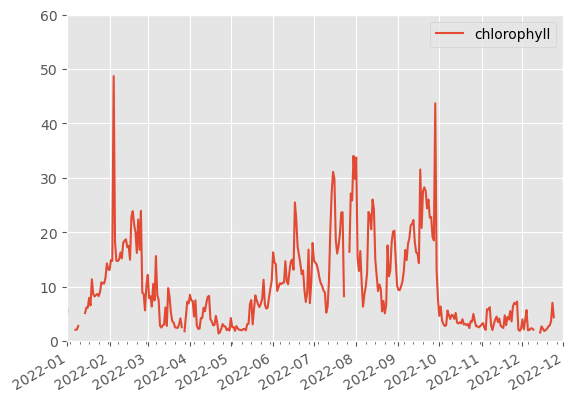

In [290]:
data_WW_byday["chlorophyll"].plot()
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xlabel("")
plt.xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2022-12-31"))
plt.ylim(0, 60)
plt.show()


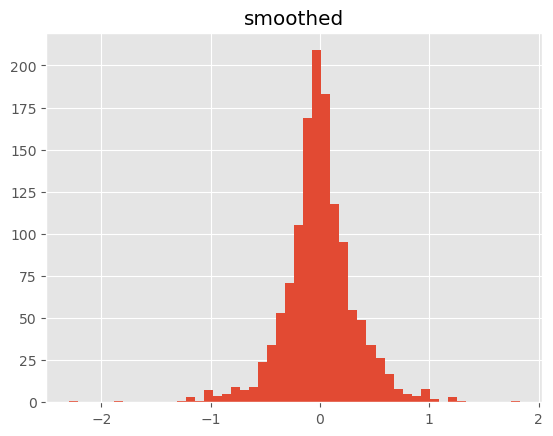

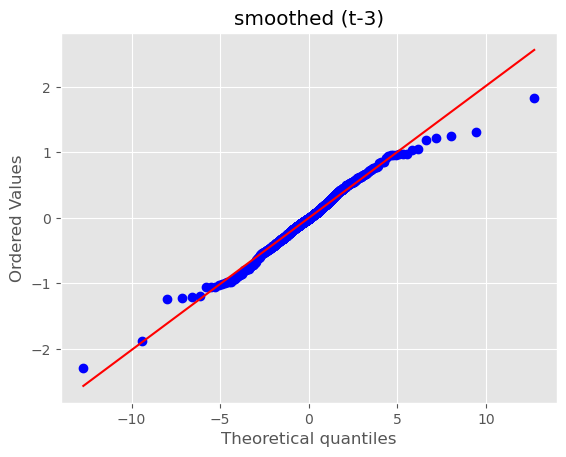

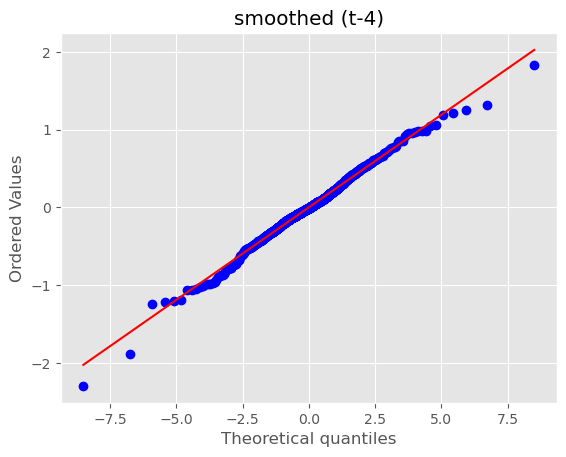

In [289]:

data_WW_byday["chlorophyll"].map(np.log).diff().hist(bins = 50)
plt.title("smoothed")
plt.show()

scipy.stats.probplot(data_WW_byday["chlorophyll"].map(np.log).diff().dropna(), dist = "t", sparams = (3), plot=plt)
plt.title("smoothed (t-3)")
plt.show()

scipy.stats.probplot(data_WW_byday["chlorophyll"].map(np.log).diff().dropna(), dist = "t", sparams = (4), plot=plt)
plt.title("smoothed (t-4)")
plt.show()


#### FFT

In [295]:
import scipy.fftpack
import scipy.signal

In [ ]:
scipy.fftpack.fftfreq(yf.size, 1 / 25e3)

In [292]:
data_WW

,date,temperature,conductivity,salinity,pH,ODO,turbidity,chlorophyll,log10_chlorophyll
time_min,,,,,,,,,
2018-10-12 12:53:04,2018-10-12,24.221,46.978,30.55,7.81,5.84,21.72,3.87,0.587711
2018-10-12 14:03:38,2018-10-12,24.615,46.755,30.38,7.86,6.37,19.17,6.34,0.802089
2018-10-12 14:17:40,2018-10-12,24.757,46.513,30.20,7.85,6.54,20.72,6.97,0.843233
2018-10-12 14:32:41,2018-10-12,24.898,46.381,30.10,7.85,6.71,21.37,7.67,0.884795
2018-10-12 14:47:41,2018-10-12,24.940,46.315,30.05,7.86,6.81,23.71,7.33,0.865104
...,...,...,...,...,...,...,...,...,...
2022-12-24 05:02:12,2022-12-24,4.105,46.071,29.17,7.84,9.80,17.23,3.00,0.477121
2022-12-24 05:17:12,2022-12-24,3.908,46.023,29.11,7.84,9.79,17.85,3.09,0.489958
2022-12-24 05:32:12,2022-12-24,3.921,46.073,29.15,7.83,9.72,21.78,3.06,0.485721


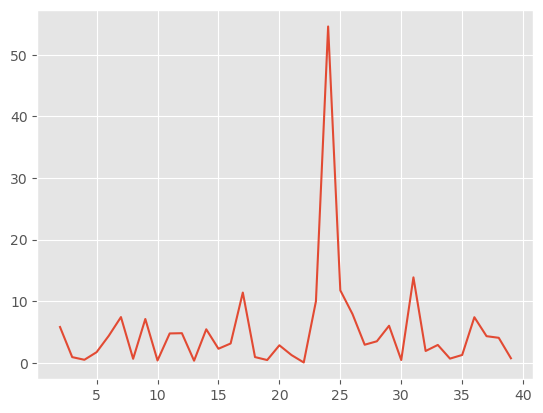

In [313]:
ang_freq = np.array(range(2, 40))
periodogram  = scipy.signal.lombscargle(((data_WW.index - pd.Timestamp('2018-10-12') ) / pd.Timedelta('1h')).to_numpy(), 
                         data_WW["chlorophyll"].to_numpy(), ang_freq)
plt.plot(ang_freq, periodogram)

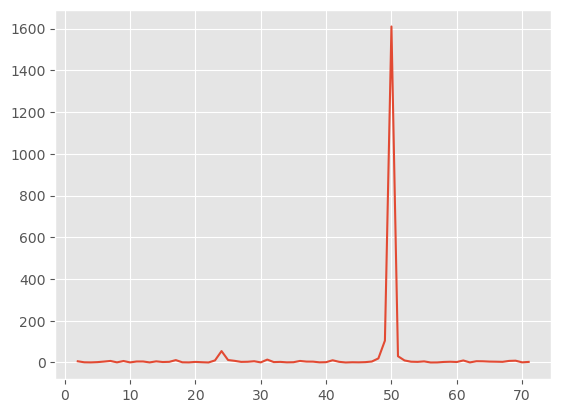

In [315]:
ang_freq = np.array(range(2, 24 * 3))
periodogram  = scipy.signal.lombscargle(((data_WW.index - pd.Timestamp('2018-10-12') ) / pd.Timedelta('1h')).to_numpy(), 
                         data_WW["chlorophyll"].to_numpy(), ang_freq)
plt.plot(ang_freq, periodogram)

## End of notebook

In [118]:
import yfinance as yf
import statsmodels.api as sm

In [592]:
sym_sp500 = "^GSPC"

# sp_assets = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# list_sym_sp500 = sp_assets[0]["Symbol"]

# list_sym_all = [sym_sp500]
# list_sym_all.extend(list_sym_sp500)

list_sym = ["AXP", "AMGN", "AAPL", "BA", "CAT", "CSCO", "CVX", "GS", "HD", "HON", "IBM", "INTC", "JNJ", "KO", "JPM",
            "MCD", "MMM", "MRK", "MSFT", "NKE", "PG", "TRV", "UNH", "CRM", "VZ", "V", "WBA", "WMT", "DIS", "DOW"]

list_sym_all = [sym_sp500]
list_sym_all.extend(list_sym)

In [611]:
data_yf = yf.download(list_sym_all, start="2000-01-01", end="2020-01-01", interval = "1mo")
# data_yf = yf.download(list_sym_all, start="1950-01-01", end="2020-01-01", interval = "1mo")

[*********************100%***********************]  31 of 31 completed


In [612]:
data_yf = data_yf["Adj Close"]

In [613]:
data_yf

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,GS,HD,HON,IBM,INTC,JNJ,JPM,KO,MCD,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,0.788424,47.323120,34.901520,28.723921,11.495279,NaN,38.283863,17.849833,28.096155,NaN,68.154518,35.292862,27.089535,61.234066,28.791489,23.766756,27.022686,15.175089,21.150511,25.322664,31.897762,30.532019,4.445224,27.313324,16.748259,5.407456,NaN,19.078138,18.119812,36.088734,1394.459961
2000-02-01,0.871067,50.666851,28.469349,23.842466,9.557376,NaN,46.215954,15.942104,26.306900,NaN,68.899788,35.838219,27.160082,56.051682,32.883751,19.883293,26.817720,12.846807,17.967323,23.851990,24.975574,27.880465,2.778265,23.814411,12.413816,5.216155,NaN,15.171306,16.741570,32.133789,1366.420044
2000-03-01,1.032076,45.604801,31.598717,24.490883,10.749921,NaN,54.060638,19.897755,31.916458,NaN,78.396782,40.201141,29.856188,64.643311,38.406223,19.469910,29.364792,12.400975,21.150511,24.108564,25.203789,33.144588,3.871252,15.379437,18.932798,6.083388,NaN,18.949600,16.720984,37.242241,1498.579956
2000-04-01,0.942784,41.610920,31.718067,25.705315,10.749921,NaN,48.477589,18.323687,33.754078,NaN,69.458450,35.241108,31.733284,60.888943,36.914352,22.865030,24.291718,12.530345,21.539564,23.581141,28.329224,21.758451,4.251452,16.192446,19.944517,6.807628,NaN,18.600826,18.263206,36.546616,1452.430054
2000-05-01,0.638339,47.276680,34.429306,25.300508,10.511102,NaN,39.813461,19.897755,32.641830,NaN,54.864162,30.563099,30.989550,58.602215,36.295792,24.805094,25.285986,14.154651,20.266287,23.342939,30.418261,19.516315,4.196399,18.105686,20.994234,7.611526,NaN,16.492476,18.425558,38.031593,1420.599976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-01,50.701096,186.647476,114.139748,357.605164,109.174446,156.070007,41.658825,99.274139,136.442535,35.003227,187.058716,208.602402,152.613663,107.764496,42.326824,116.239845,97.954468,49.001381,199.838242,140.562225,73.256004,132.794662,81.536880,110.279968,134.674561,221.453537,176.378738,48.443760,43.813148,107.454834,2926.459961
2019-09-01,54.607018,174.355453,112.157898,376.025269,115.880867,148.440002,43.972717,101.044403,129.543869,39.780014,191.297440,212.364227,157.647675,116.990768,46.315708,118.041466,104.935928,48.467216,197.890335,144.199112,71.315933,134.367630,90.860657,114.086494,136.259918,205.667877,168.027191,50.276234,47.772865,112.160988,2976.739990
2019-10-01,60.651173,192.141510,111.209671,335.939117,126.422150,156.490005,42.281788,98.948540,129.146255,42.150955,196.974579,216.018478,160.936661,107.586143,50.809757,120.468361,111.382408,48.812603,181.291122,144.716644,73.904877,138.562073,86.633026,114.205750,120.751579,240.278625,174.718597,50.367855,47.315094,110.818985,3037.560059


In [614]:
data_ret = data_yf.applymap(np.log).diff()
# data_ret = data_yf[data_yf.index.to_series().between(pd.Timestamp("1950-01-01"), pd.Timestamp("2000-01-01"))].applymap(np.log).diff()

In [615]:
#riskfree_rate = 0.03 / 12
riskfree_rate = 0.

AXP


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0003,0.004,0.064,0.949,-0.008,0.008
beta,1.3826,0.093,14.811,0.000,1.199,1.567


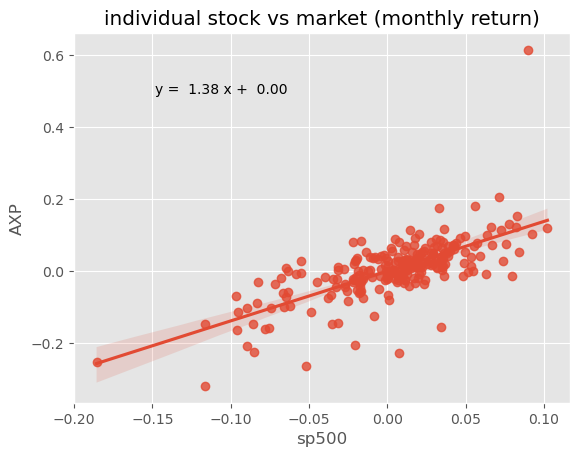

AMGN


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0042,0.004,0.961,0.338,-0.004,0.013
beta,0.6269,0.103,6.068,0.000,0.423,0.830


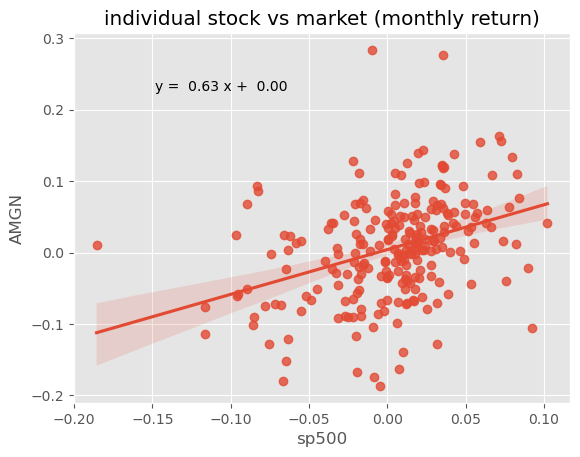

AAPL


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0138,0.007,1.972,0.050,1.36e-05,0.028
beta,1.4467,0.165,8.752,0.000,1.121,1.772


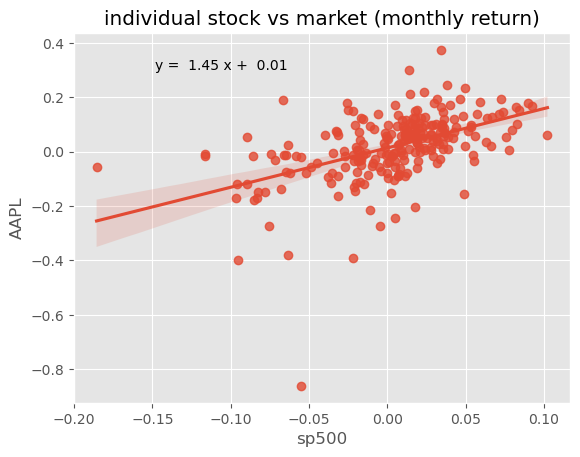

BA


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0064,0.005,1.396,0.164,-0.003,0.015
beta,1.0742,0.108,9.978,0.000,0.862,1.286


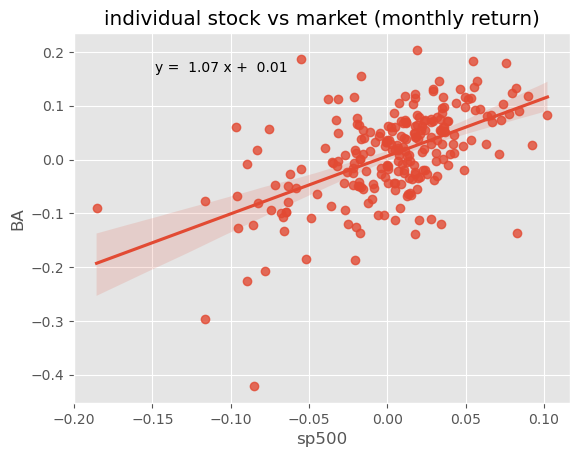

CAT


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0052,0.004,1.175,0.241,-0.003,0.014
beta,1.4803,0.104,14.289,0.000,1.276,1.684


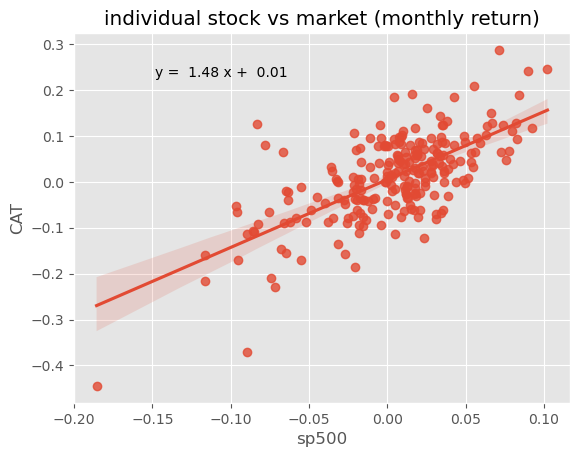

CSCO


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,-0.0050,0.005,-1.016,0.311,-0.015,0.005
beta,1.5644,0.117,13.414,0.000,1.335,1.794


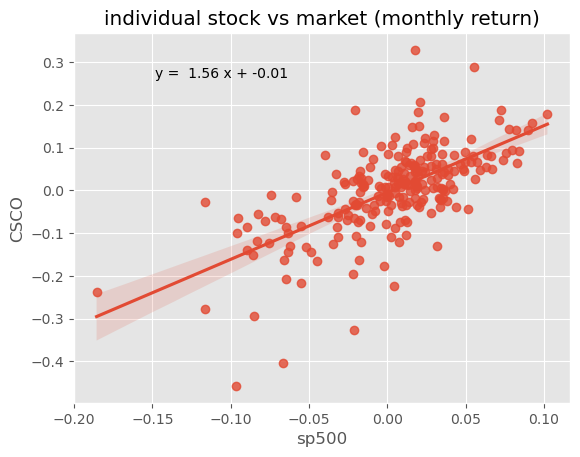

CVX


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0046,0.003,1.449,0.149,-0.002,0.011
beta,0.7737,0.076,10.216,0.000,0.624,0.923


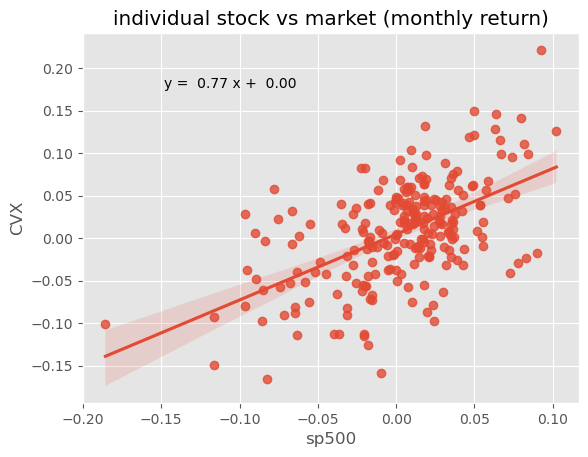

GS


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,-0.0004,0.004,-0.100,0.921,-0.009,0.008
beta,1.4810,0.102,14.566,0.000,1.281,1.681


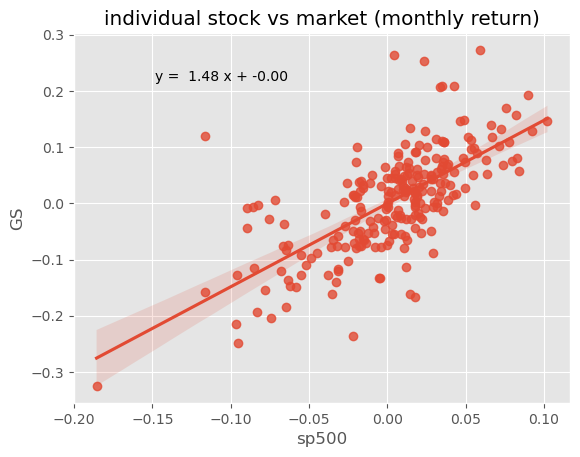

HD


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0037,0.004,0.998,0.319,-0.004,0.011
beta,1.0136,0.088,11.513,0.000,0.840,1.187


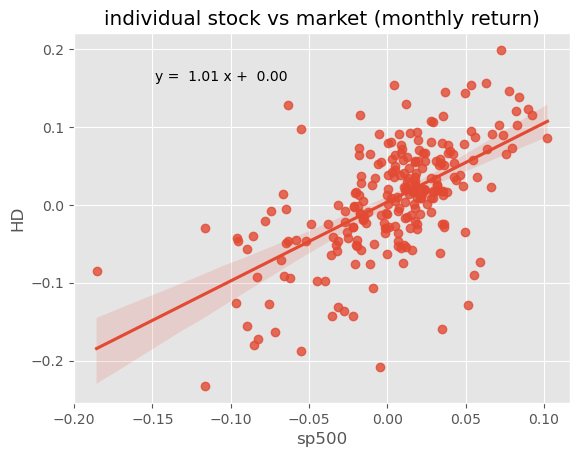

HON


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0029,0.004,0.701,0.484,-0.005,0.011
beta,1.3300,0.098,13.581,0.000,1.137,1.523


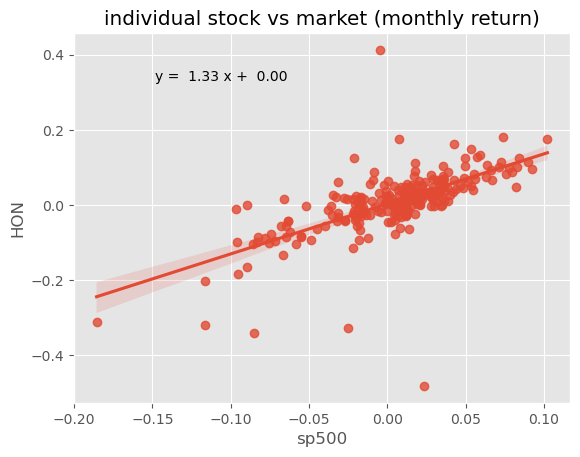

IBM


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,-0.0014,0.004,-0.399,0.690,-0.009,0.006
beta,1.0960,0.085,12.882,0.000,0.928,1.264


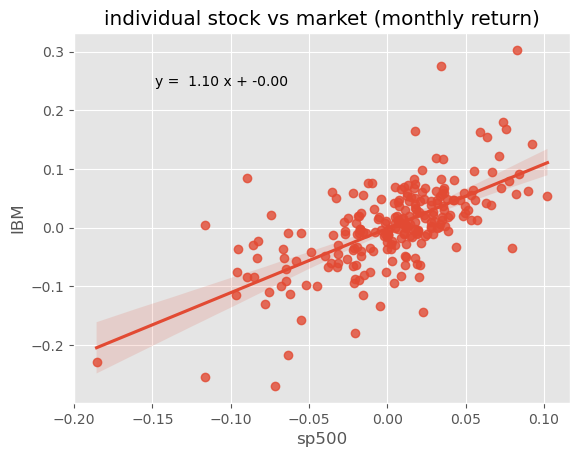

INTC


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,-0.0025,0.005,-0.475,0.635,-0.013,0.008
beta,1.4560,0.123,11.810,0.000,1.213,1.699


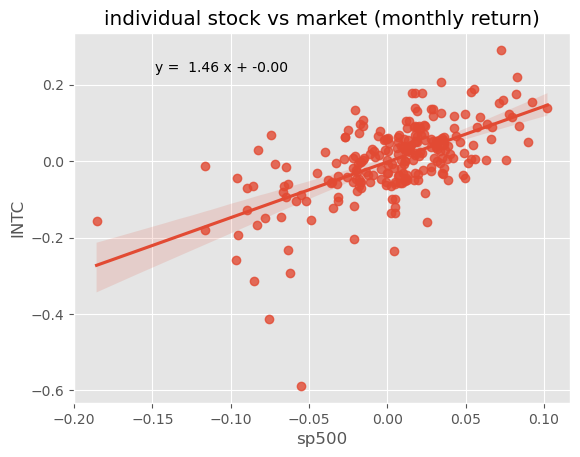

JNJ


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0056,0.003,2.005,0.046,9.78e-05,0.011
beta,0.4651,0.066,7.043,0.000,0.335,0.595


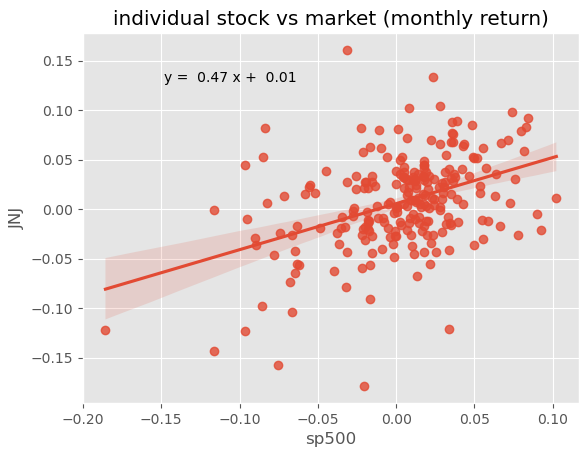

KO


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0034,0.003,1.148,0.252,-0.002,0.009
beta,0.4528,0.070,6.474,0.000,0.315,0.591


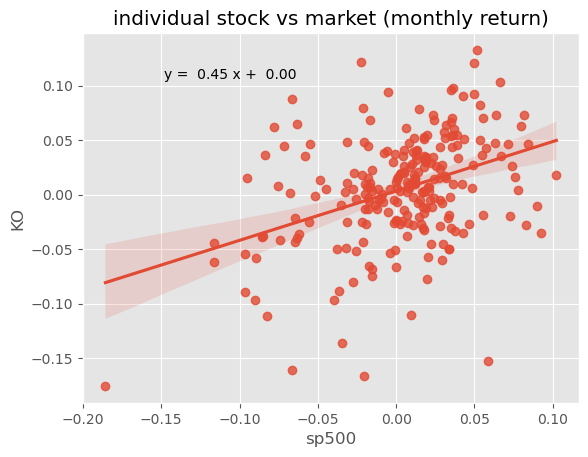

JPM


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0014,0.004,0.333,0.740,-0.007,0.009
beta,1.4395,0.096,14.921,0.000,1.249,1.630


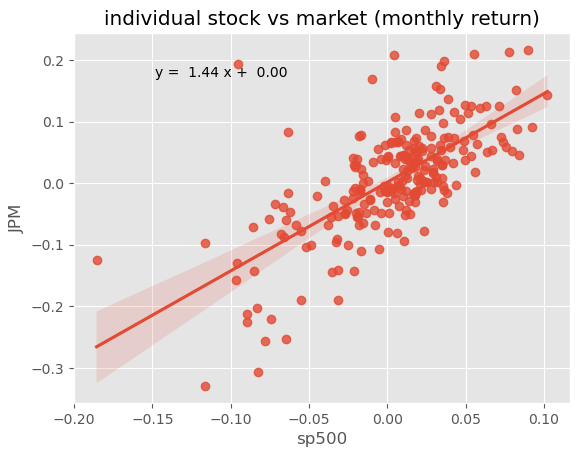

MCD


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0068,0.003,2.124,0.035,0.000,0.013
beta,0.6305,0.076,8.311,0.000,0.481,0.780


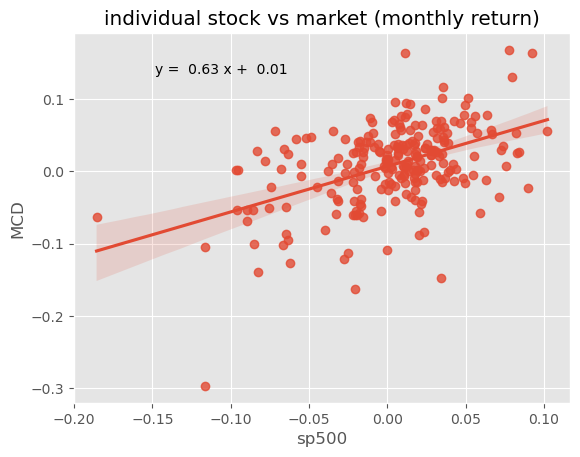

MMM


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0048,0.003,1.574,0.117,-0.001,0.011
beta,0.8023,0.072,11.154,0.000,0.661,0.944


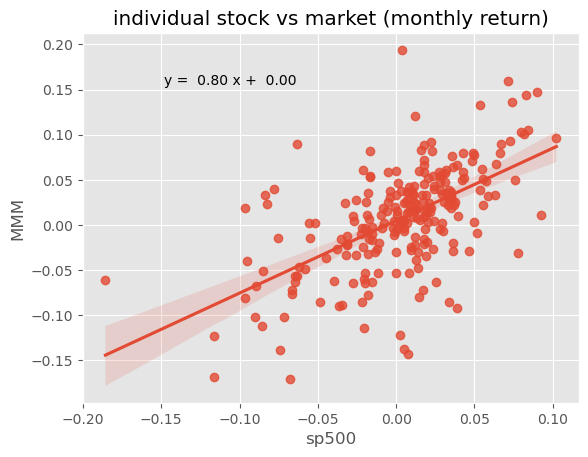

MRK


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0017,0.004,0.403,0.688,-0.007,0.010
beta,0.5675,0.101,5.612,0.000,0.368,0.767


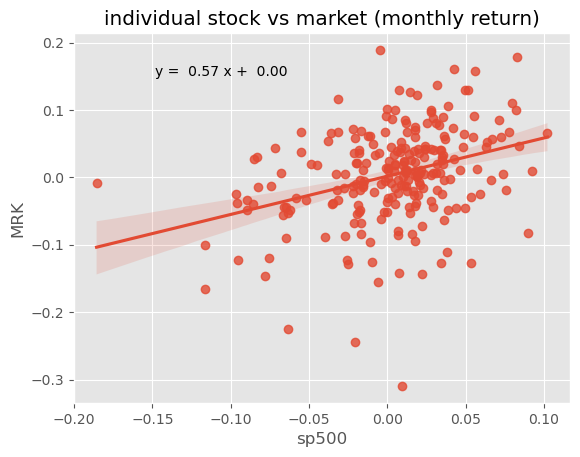

MSFT


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0026,0.004,0.595,0.552,-0.006,0.011
beta,1.1824,0.103,11.518,0.000,0.980,1.385


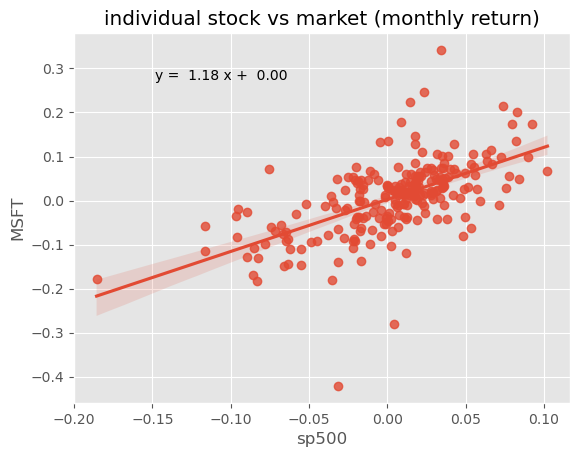

NKE


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0101,0.004,2.257,0.025,0.001,0.019
beta,0.8091,0.106,7.642,0.000,0.600,1.018


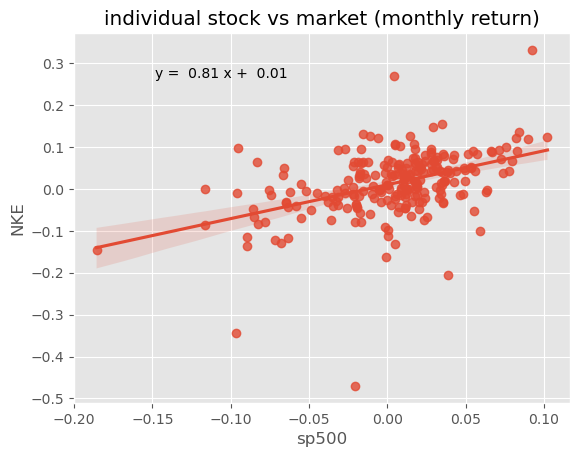

PG


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0052,0.003,1.506,0.133,-0.002,0.012
beta,0.2411,0.081,2.967,0.003,0.081,0.401


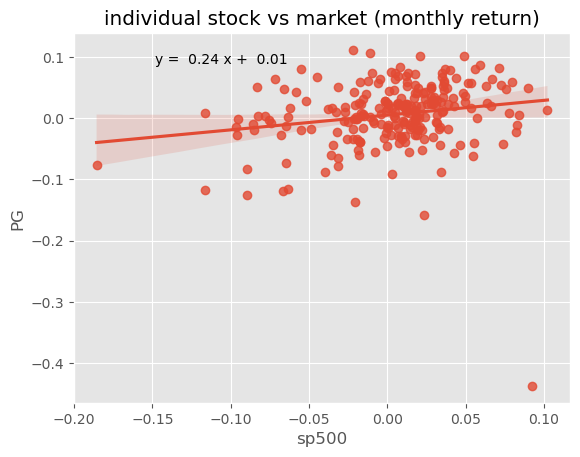

TRV


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0055,0.004,1.451,0.148,-0.002,0.013
beta,0.8251,0.090,9.131,0.000,0.647,1.003


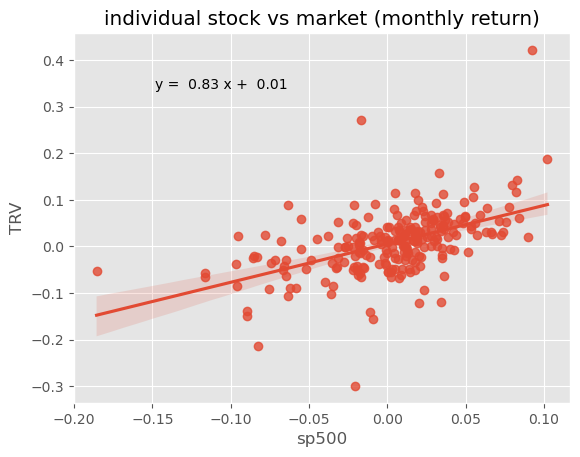

UNH


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0143,0.004,3.278,0.001,0.006,0.023
beta,0.6380,0.103,6.204,0.000,0.435,0.841


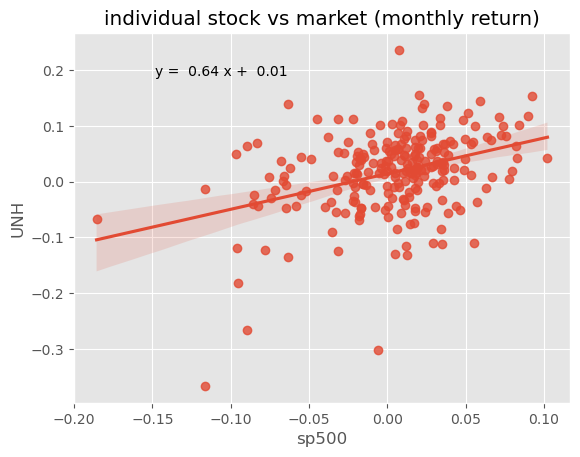

CRM


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0127,0.007,1.893,0.060,-0.001,0.026
beta,1.4545,0.166,8.741,0.000,1.126,1.783


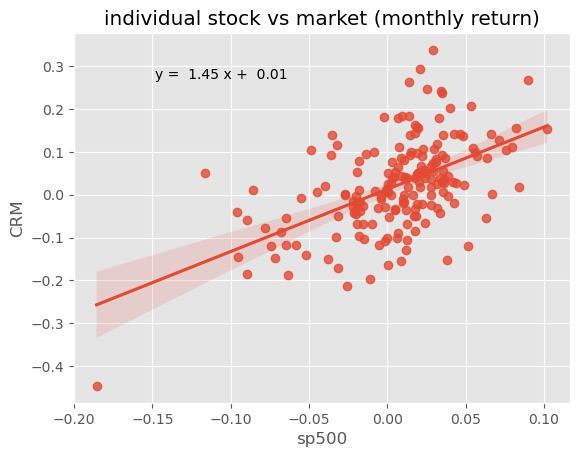

VZ


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0018,0.004,0.492,0.623,-0.006,0.009
beta,0.6617,0.089,7.470,0.000,0.487,0.836


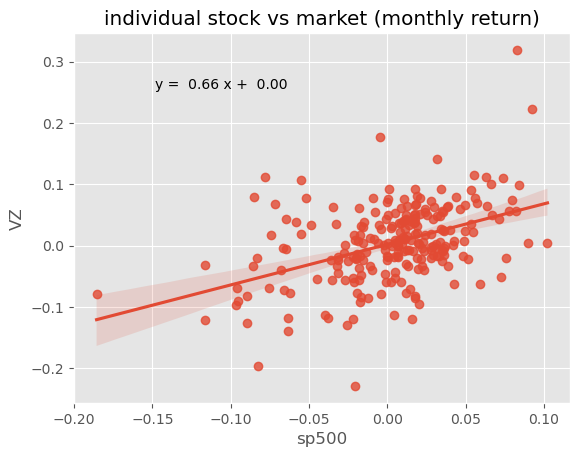

V


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0117,0.004,2.896,0.004,0.004,0.020
beta,0.7640,0.092,8.349,0.000,0.583,0.945


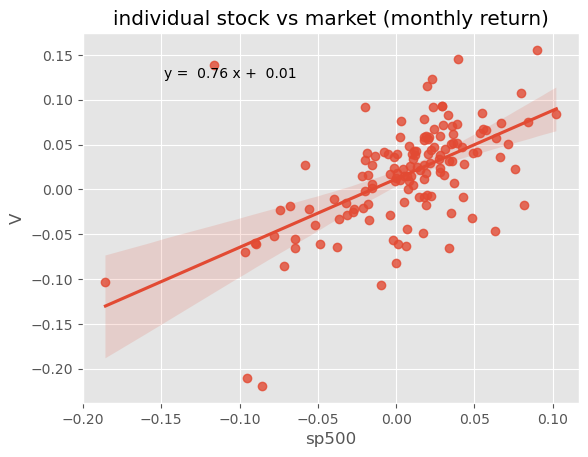

WBA


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0017,0.004,0.404,0.687,-0.007,0.010
beta,0.7415,0.102,7.246,0.000,0.540,0.943


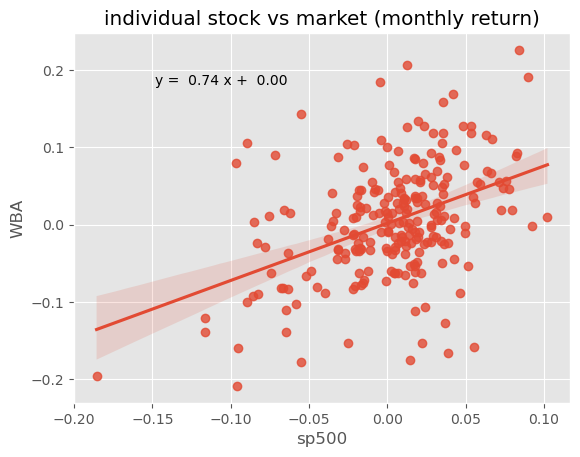

WMT


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0034,0.003,1.014,0.311,-0.003,0.010
beta,0.3975,0.078,5.089,0.000,0.244,0.551


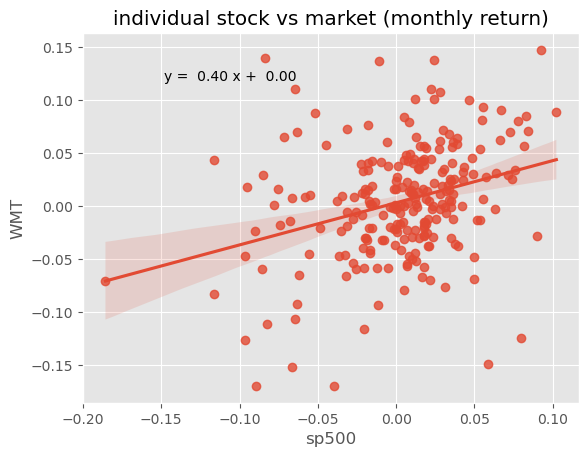

DIS


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,0.0028,0.003,0.854,0.394,-0.004,0.009
beta,1.1479,0.077,14.842,0.000,0.996,1.300


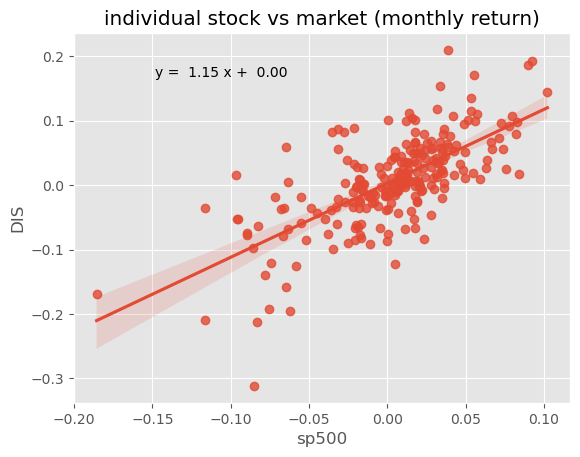

DOW


,coef,std err,t,P>|t|,[0.025,0.975]
alpha,-0.0259,0.023,-1.149,0.294,-0.081,0.029
beta,2.3316,0.578,4.034,0.007,0.917,3.746


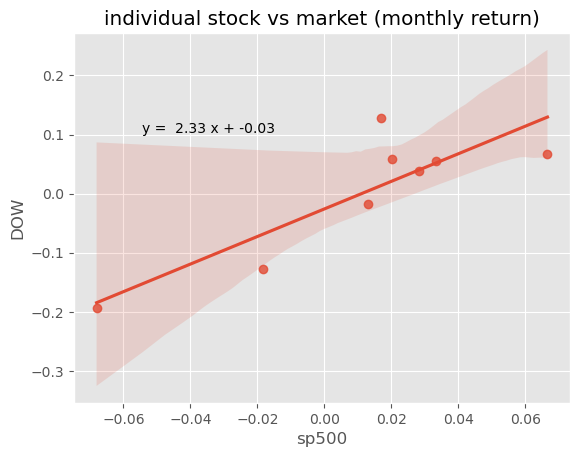

In [619]:
list_alpha = []
list_beta = []
list_avg_return = []
list_asset_used = []
# for tmp_sym in list_sym_sp500:
for tmp_sym in list_sym:

    tmp_data_yf = data_ret[[tmp_sym, sym_sp500]].dropna()
    
    print(tmp_sym)
    if len(tmp_data_yf) == 0:
        print("Error: no data")
        continue
    
    tmp_model = sm.OLS(exog =  sm.add_constant(tmp_data_yf[sym_sp500] - riskfree_rate).rename(columns = {"const": "alpha", "^GSPC": "beta"}), endog =  tmp_data_yf[tmp_sym] - riskfree_rate ).fit()
    tmp_alpha, tmp_beta = tmp_model.params[0], tmp_model.params[1]
    list_alpha.append(tmp_alpha)
    list_beta.append(tmp_beta)
    
    # tmp_model = sm.OLS(exog =  tmp_data_yf[sym_sp500] - riskfree_rate, endog =  tmp_data_yf[tmp_sym] - riskfree_rate ).fit()
    # list_beta.append(tmp_model.params[0])
    # list_alpha.append(0.)
    
    display(tmp_model.summary().tables[1])
    
    sns.regplot(data = tmp_data_yf, x = sym_sp500, y = tmp_sym, fit_reg = True)
    plt.xlabel("sp500")
    plt.text(min(tmp_data_yf[sym_sp500]) * 0.8, max(tmp_data_yf[tmp_sym]) * 0.8, 'y = % .2f x + % .2f' % (tmp_beta, tmp_alpha))
    plt.title("individual stock vs market (monthly return)")
    plt.show()
    
    list_avg_return.append(tmp_data_yf[sym_sp500].mean() * 12)
    list_asset_used.append(tmp_sym)


In [617]:
data_asset_alpha_beta = pd.DataFrame({"alpha": list_alpha, "beta": list_beta, "avgret": list_avg_return, "asset": list_asset_used, })

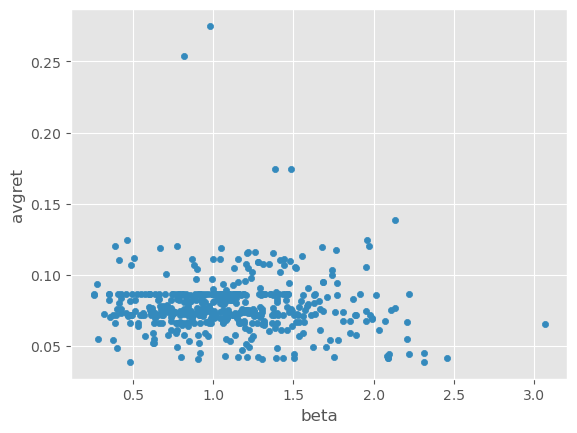

In [482]:
data_asset_alpha_beta.plot.scatter(x = "beta", y = "avgret")
plt.show()

In [483]:
list_quantile = [0., 0.2, 0.4, 0.6, 0.8, 1.0]
# list_quantile = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
data_asset_alpha_beta["beta_bin"] = pd.qcut(data_asset_alpha_beta["beta"], list_quantile)

<AxesSubplot:xlabel='beta', ylabel='avgret'>

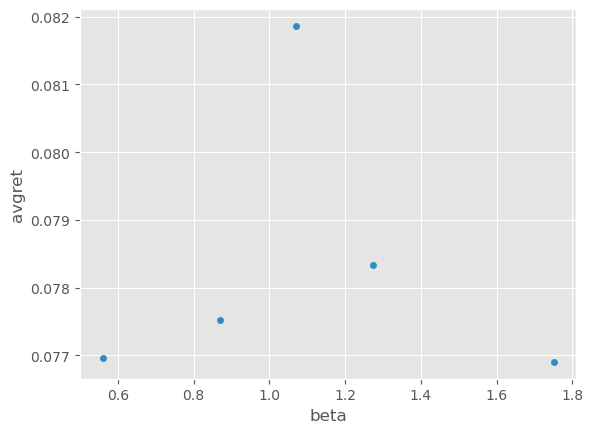

In [485]:
data_asset_alpha_beta.groupby("beta_bin").agg("mean").plot.scatter(x = "beta", y = "avgret")

In [19]:
tmp = pd.DataFrame({"tmp": np.arange(1000)})
tmp["tmp"] = tmp["tmp"].map(lambda x: 1 if x % 2 == 0 else np.nan)

In [22]:
tmp.rolling(10, min_periods=1).sum()

,tmp
0,1.0
1,1.0
2,2.0
3,2.0
4,3.0
...,...
995,5.0
996,5.0
997,5.0
998,5.0
